# Analysis of the *escort* market in UK

In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a onclick="code_toggle()" href=#>Show source</a>'''))

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import sys
import cPickle
from vaderSentiment.vaderSentiment import sentiment
from collections import Counter
from IPython.core.display import display, HTML
from IPython.display import Image
import datetime
from stop_words import get_stop_words
import locale
locale.setlocale(locale.LC_TIME, "en_US.UTF-8")
from wordcloud import WordCloud, STOPWORDS
from dateutil.relativedelta import relativedelta
import operator
from ipy_table import *
from collections import Counter
stop_words = get_stop_words('en')
stop_words.extend(['will','her','time','get','can','got','just','didnt','much','done','thing'])

import sys
reload(sys)
sys.setdefaultencoding('utf-8')


import seaborn as sb
sb.set_style("darkgrid")

def displayTable(table, theme='basic'):
    make_table(table)
    apply_theme(theme)
    return set_global_style(float_format="%.2f")
    
def displaySeries(s, width=False):
    res = []
    res.append([s.index.name, s.name])
    for k,v in s.iteritems():
            if width:
                if len(v)>width:
                    res.append([k, v[:width]+"..."])
                else:
                    res.append([k, v[:width]])
            else:
                res.append([k, v])
    return displayTable(res)

def displayDataFrame(s, width=False):
    res = []
    for k,v in s.iteritems():
            if width:
                if len(str(v.iloc[0]))>width:
                    res.append([k, str(v.iloc[0])[:width]+"..."])
                else:
                    res.append([k, str(v.iloc[0])[:width]])
            else:
                res.append([k, str(v.iloc[0])])
    return displayTable(res)


def makeWordCloud(words):
    wordcloud = WordCloud(#font_path='/home/fcheung/CabinSketch-Bold.ttf'
                            stopwords=STOPWORDS,
                            background_color='white',
                            width=1800,
                            height=1400,
                           ).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
with open("data/escort/datasets/reviews.pickle") as f:
    df_reviews = cPickle.load(f)
    df_reviews = df_reviews[df_reviews.visit_date.dt.year>1999]
    df_reviews = df_reviews[df_reviews.visit_date.dt.year<=2016]
    # Until 31-oct-2016 (full month)
    df_reviews = df_reviews[df_reviews.visit_date<datetime.datetime(2016,11,1)]


In [4]:
with open("data/escort/datasets/providers.pickle") as f:
    df_providers = cPickle.load(f)

In [5]:
df = pd.merge(left = df_reviews, right = df_providers, on = 'id_service_provider', how = 'left')

**Disclaimer and Motivation**

I've experienced that *many* otherwise quiet and thoughtful people are outraged when some subjects are treated. The escort business &mdash;and prostitution in general&mdash; is such a topic. In case you find yourself offended by the subject, please read this section in full (and thanks for reaching here).

I am a data analyst, and my motivation is to analyze a market somehow in the *shadows*, or at least not in the public spot. The decision to go for this market was threefold:

1. The business owners are not *necessarily* technical people. That means, I cannot impress them with Principal Component Analysis, unsupervised clustering or clever dimension reductions. If I don't give them business *insights* I wasted their time.

2. There is a wealth of data available thanks to the review site *Punternet.com*. It was structured enough to be able to efficiently extract information, and at the same time free enough to be a challenge -i.e. free text descriptions, free text in the *date* field, etc.-. I applied basic statistics as well as Natural Language Processing techniques for this report.

3. It is an *interesting* market from an economic point of view. I find a challenge to price the time of an escort. Usually the equilibrium price &mdash;*given from the offer-supply&mdash;* comes from the cost of production (in *very broad* terms), but here, the cost of the provider is null. It is not even like the case of consultants, where their time is priced (more or less) according to the cost of their education *and* opportunity costs. In any case, there *must* be a cost for the escort, or all girls in the world would be doing it (and driving their price down). So, that's *why* it's interesting. That, and that it is not a openly, analyzed-to-death market, like, for example, real estate.

# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="Foreword-1" href="#Foreword"><span class="toc-item-num">1&nbsp;&nbsp;</span>Foreword</a></div><div class="lev1 toc-item"><a data-toc-modified-id="A-global-glimpse-2" href="#A-global-glimpse"><span class="toc-item-num">2&nbsp;&nbsp;</span>A global glimpse</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Origin-of-the-data-21" href="#Origin-of-the-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Origin of the data</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Analyzing-the-time-of-visits-22" href="#Analyzing-the-time-of-visits"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyzing the time of visits</a></div><div class="lev2 toc-item"><a data-toc-modified-id="How-many-go-to-escorts?-23" href="#How-many-go-to-escorts?"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>How <em>many</em> go to escorts?</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Cost.-Price.-Income.-Let's-talk-about-money.-24" href="#Cost.-Price.-Income.-Let's-talk-about-money."><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Cost. Price. Income. Let's talk about money.</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Income-per-visit-241" href="#Income-per-visit"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Income per visit</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Income-per-hour-242" href="#Income-per-hour"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Income per hour</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Cost-of-visit-at-different-times-243" href="#Cost-of-visit-at-different-times"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Cost of visit at different times</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Analysis-on-veteranity-25" href="#Analysis-on-veteranity"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Analysis on veteranity</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Analysis-of-profiles-26" href="#Analysis-of-profiles"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Analysis of profiles</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Analysis-on-preferences-(or-how-I-discovered-what-are-really-people-into)-3" href="#Analysis-on-preferences-(or-how-I-discovered-what-are-really-people-into)"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis on preferences (or how I discovered what are <em>really</em> people into)</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Do-gentlemen-prefer-blondes?-31" href="#Do-gentlemen-prefer-blondes?"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Do gentlemen prefer blondes?</a></div><div class="lev2 toc-item"><a data-toc-modified-id="What-offers-the-market?-An-Introduction-32" href="#What-offers-the-market?-An-Introduction"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>What offers the market? An Introduction</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Most-lucrative-fetishes-33" href="#Most-lucrative-fetishes"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Most lucrative fetishes</a></div><div class="lev2 toc-item"><a data-toc-modified-id="SM?-Tattoos?-34" href="#SM?-Tattoos?"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>SM? Tattoos?</a></div><div class="lev1 toc-item"><a data-toc-modified-id="A-look-at-the-descriptions-4" href="#A-look-at-the-descriptions"><span class="toc-item-num">4&nbsp;&nbsp;</span>A look at the descriptions</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Why-do-men-go-to-escorts?-5" href="#Why-do-men-go-to-escorts?"><span class="toc-item-num">5&nbsp;&nbsp;</span>Why do men go to escorts?</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Epilogue-and-Conclusion-6" href="#Epilogue-and-Conclusion"><span class="toc-item-num">6&nbsp;&nbsp;</span>Epilogue and Conclusion</a></div>

# Foreword

There is an old joke about a drunkard who is searching for something he has lost
> A policeman sees a drunk man searching for something under a streetlight and asks what the drunk has lost. He says he lost his keys and they both look under the streetlight together. After a few minutes the policeman asks if he is sure he lost them here, and the drunk replies, no, and that he lost them somewhere along his way home. The policeman asks why he is searching here, and the drunk replies, "this is where the light is."

This joke shows what is called the *Streetlight Effect*, the bias often present in scientific research. I noticed that reviewers take their time to write long, well articulated reviews, that led me to the conclusion that these clients are mostly well educated. This fact may *bias* the results, since less educated &mdash;or even illiterate&mdash; clients **are not represented**. It **may be possible** that the most part of clients are *aggressive, illiterate* individuals, and that this dataset shows just the *nice* ones. Maybe, but *unlikely*. There's another aphorism that says *If it looks like a duck, and quacks like a duck, we have probably a duck*, so probably we are analyzing, *at least*, a representative sample of the population. Just don't forget that although data *might* not lie, **we can only search where there is light**.


# A global glimpse

## Origin of the data

The review site *Punternet.com* is a meeting point of *punters* (escort clients) to share their experiences. It has been active from *1999* and to date (2016) reviews keep arriving in a steady fashion. This provides a wealth of information to analyze and extract information from such closed market.

Here is a screenshot of one random **review** and one **provider**.

<table style="width:100%; border:0px">
    <tr>
        <th><center>Example Review</center></th>
        <th><center>Example Provider</center></th>
    </tr>
    <tr>
        <td style="vertical-align: top">
           <img src="data/escort/img/review_screenshot.png" style="width: 600px;">
         </td>
        <td style="vertical-align: top">
           <img src="data/escort/img/provider_screenshot.png" style="width: 600px;">
         </td>
        
    </tr>
</table> 

In addition to standard data like *location*, *date* and *price* there are two *free text* sections, *The Lady*, where the looks and first impression of the lady is described, and *The Story*, where the client tells in detail how the session evolved.

Regarding the providers, profiles may be more or less complete, but commonly found information includes *Name of the Lady*, *Prices*, *List of services*, *Phone Number*, a *short description* and possibly a *Photo Gallery*.

In [6]:
display(Markdown("This dataset contains **%d** reviews of **%d** providers from 1999 to today (2016)" % (df.shape[0], df_providers.shape[0])))

This dataset contains **32115** reviews of **715** providers from 1999 to today (2016)

As a first exploratory step, let's analyze the number of visits per month, in order to gauge the popularity (and thus *relevance*) of the site *Punternet.com* in the escort industry.

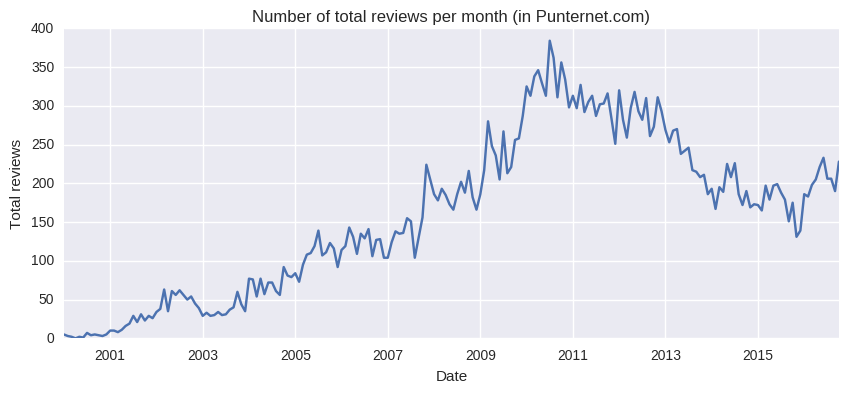

In [7]:
plt.figure()
by_month = df.groupby(pd.Grouper(key='visit_date', freq='1M')).size().plot()
plt.title("Number of total reviews per month (in Punternet.com)")
plt.xlabel("Date")
plt.ylabel("Total reviews")
plt.show()

It seems that *Punternet.com* grew from less than **10** reviews per month in the year 2000 (according to their site they *Established [in] 1999*)to a peak of almost **400** reviews per month about 2011. Since then, it seems to be *declining* to the current value, **200-250** reviews *per month*.
It could mean the escort industry has been declining *or* that Punternet it losing popularity. For that purpose, we check Google trends.

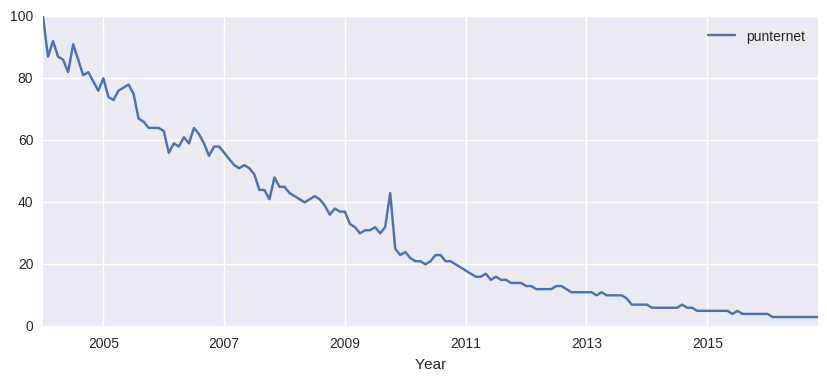

In [8]:
gt = pd.read_csv("data/escort/aux/googletrends.csv", index_col="Monat")
gt.index = pd.to_datetime(gt.index, format='%Y-%m')
gt.plot()
plt.xlabel("Year")
plt.show()

What's interesting in this chart is that (according to Google Trends) Punternet.com has been in decline since *at least* 2005, with an anecdotal spike in 2009 (maybe an article in mainstream media?). That means that the previous peak in visits in 2011 existed *despite* the fact that the website's popularity was *decreasing*. That leads to believe that in 2011 there were a decreasing number of *very active* users.

In order to verify that let's plot the number of *different* users per month:

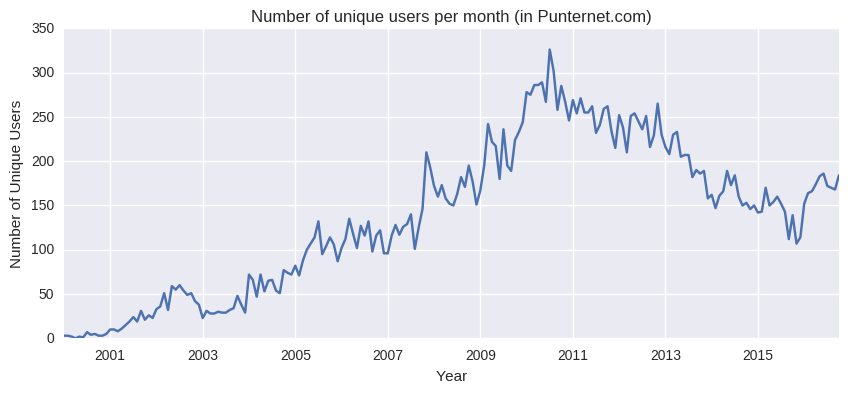

In [9]:
plt.figure()
by_month = df.groupby(pd.Grouper(key='visit_date', freq='1M')).author_link.apply(lambda x: len(x.unique())).plot()
plt.title("Number of unique users per month (in Punternet.com)")
plt.xlabel("Year")
plt.ylabel("Number of Unique Users")
plt.show()

Well, that was *unexpected*. It seems that around 2011 the number of unique reviewers also spiked! Indeed, the number of reviews per user (per month) is fairly constant:

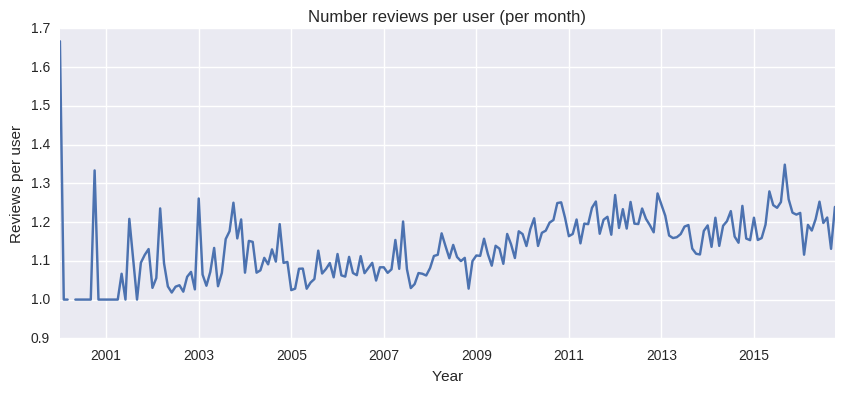

In [10]:
by_month = df.groupby(pd.Grouper(key='visit_date', freq='1M')).size()
by_month2 = df.groupby(pd.Grouper(key='visit_date', freq='1M')).author_link.apply(lambda x: len(x.unique()))
(by_month/by_month2).plot()
plt.title("Number reviews per user (per month)")
plt.xlabel("Year")
plt.ylabel("Reviews per user")
plt.show()

All this points to the fact that Punternet was growing in popularity around *end 2010*, despite Google searches declining. That means clients do not reach the site through Google. Two hypothesis can explain this fact:

1. Clients reach the website directly (*Word of mouth*).
2. There are other advertising networks (like escort websites associations?) that send traffic to the site.

Let's show the number of *different* clients that ever posted a review on the site by month

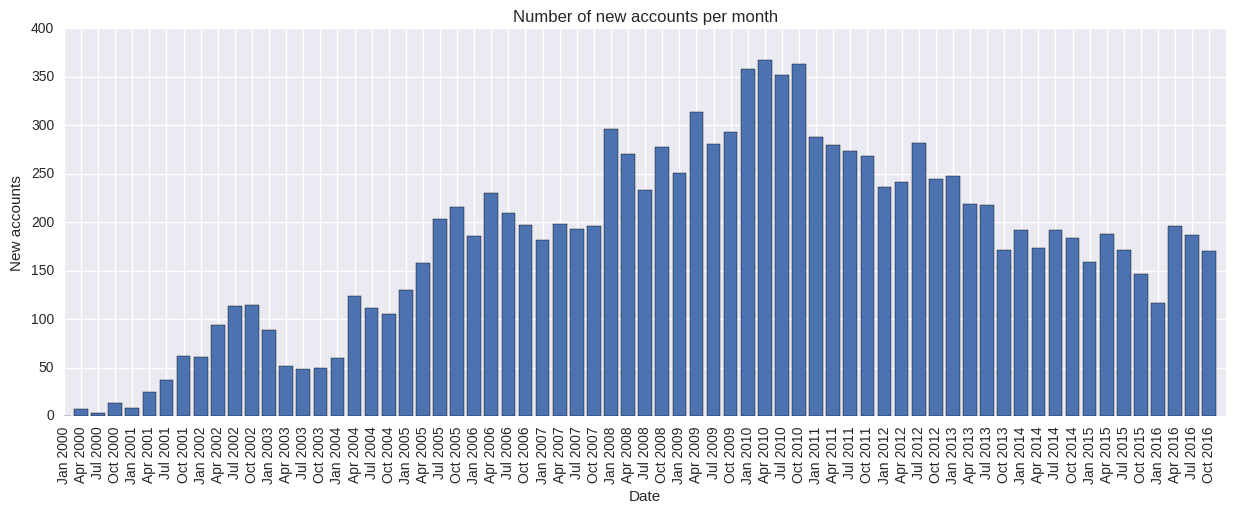

In [11]:
plt.figure(figsize=(15,5))
d0 = datetime.datetime(2000,1,1)
d1 = datetime.datetime(2016,10,2)
d = d0


labels= []
Y= []
while d<d1:

        labels.append(d.strftime("%b %Y"))
        Y.append(df_reviews[df_reviews.visit_date<d].author_link.nunique())


        d+= relativedelta(months=3)

plt.bar(range(len(labels)), [0]+list(np.diff(Y)), tick_label=labels, align='center')
plt.title("Number of new accounts per month")
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("New accounts")
plt.xlim([0,len(labels)])
plt.show()

This values are to be taken with a grain of salt since due to the anonymity of the site a single user can create multiple accounts. Anyway it gives a global insight of the trend. It seems that most *new* accounts have been created around *end 2010*.

Data points to the fact that *Punternet.com* is **declining** in both *usage* and *engagement*. The question arises, where are *these people* going? And, *is in this new place information so well structured like in Punternet.com?*

## Analyzing the time of visits

This *a posteriori* obvious fact caught me by surprise. Let's take a look at the hour at which the visits take place more often.

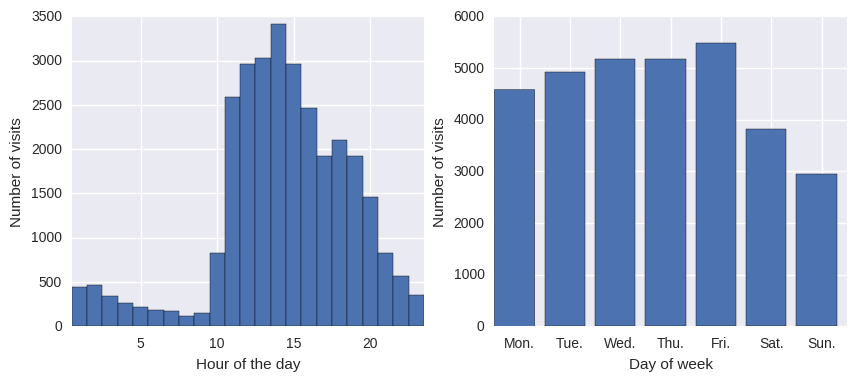

In [12]:
plt.figure()
plt.subplot(121)
df.visit_date.dt.hour.hist(bins = np.arange(25)-0.5)
plt.xlim(0.5,23.5)
plt.xlabel("Hour of the day")
plt.ylabel("Number of visits")


plt.subplot(122)
ax = df.visit_date.dt.weekday.hist(bins = np.arange(8)-0.5, width=0.8)
tmp = ax.get_xticks().tolist()
tmp[1:8] = ["Mon.","Tue.","Wed.","Thu.","Fri.","Sat.","Sun."]
ax.set_xticklabels(tmp)
plt.xlim(-0.5,6.5)
plt.xlabel("Day of week")
plt.ylabel("Number of visits")
plt.show()
plt.show()

The graph on the *left* shows that visits are not during **night-time**, but instead during **working hours**. 
This is complemented by the graph on the *right*, that shows the number of visits **per day of week**.

We see that visits during the weeks are a *50% higher* than on weekends! So, visits take place on *work days during working hours*. The question is, *who* goes to the ladies on Sundays? Let's check if this distribution is the same every day of the week.

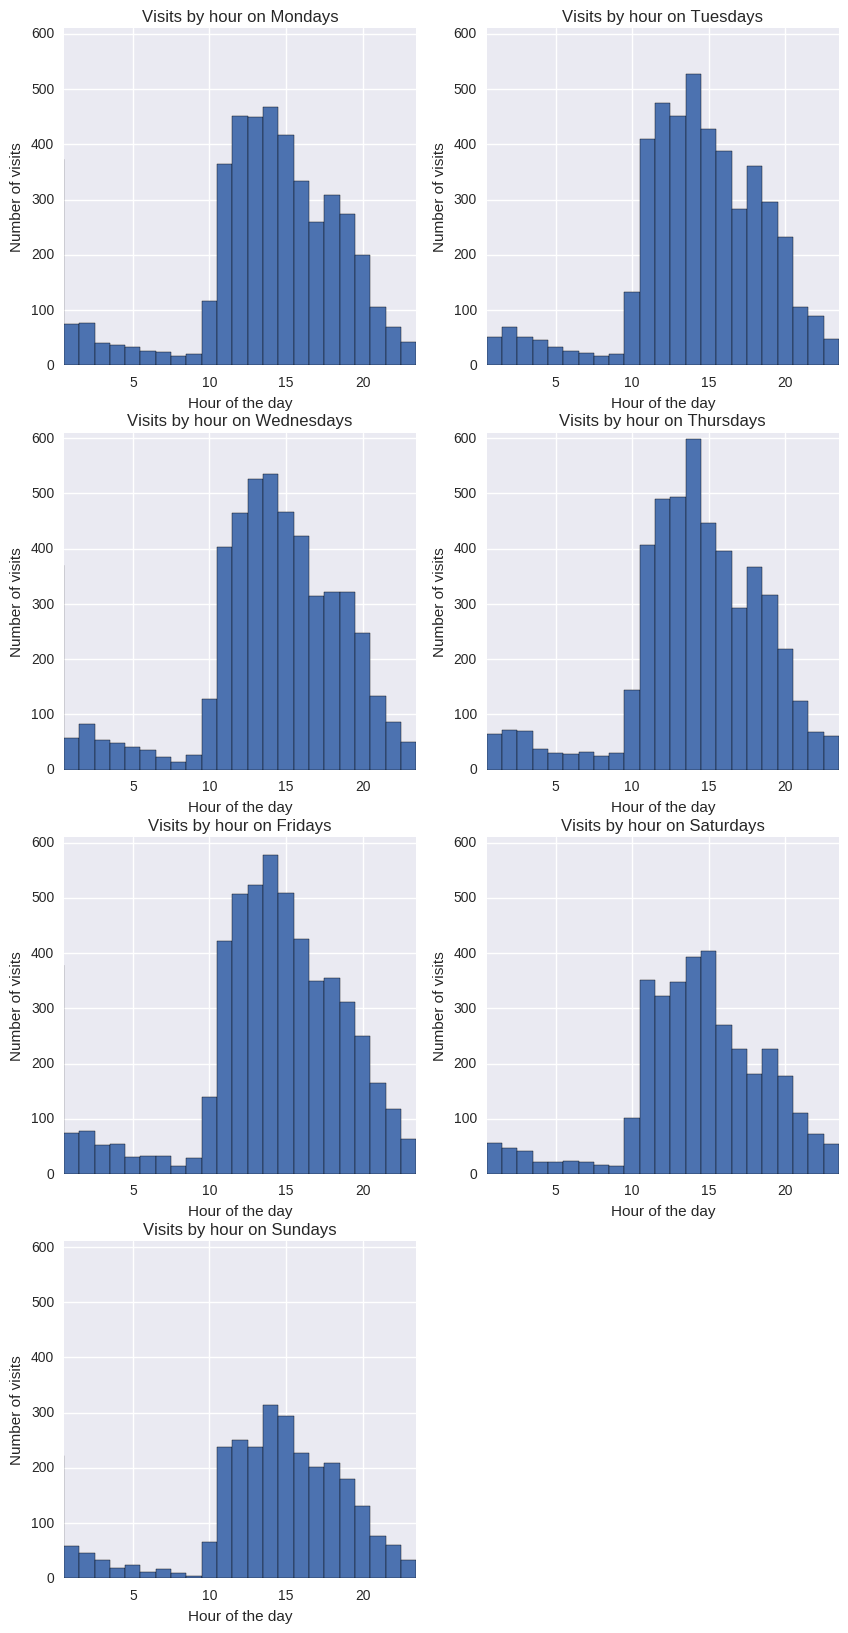

In [13]:
plt.figure(figsize=(10, 20))
weekdays = ["Mondays","Tuesdays","Wednesdays","Thursdays","Fridays","Saturdays","Sundays"]
for i in range(7):
        plt.subplot(4,2,i+1)
        df[df.visit_date.dt.weekday==i].visit_date.dt.hour.hist(bins = np.arange(25)-0.5)
        plt.title("Visits by hour on "+weekdays[i])
        plt.xlim(0.5,23.5)
        plt.xlabel("Hour of the day")
        plt.ylabel("Number of visits")
        plt.ylim((0,610))
plt.show()

Interestingly enough, people who go on Sundays also go on *working hours*. Maybe people who work on Sundays too?

To confirm, this distribution is also constant across the years.

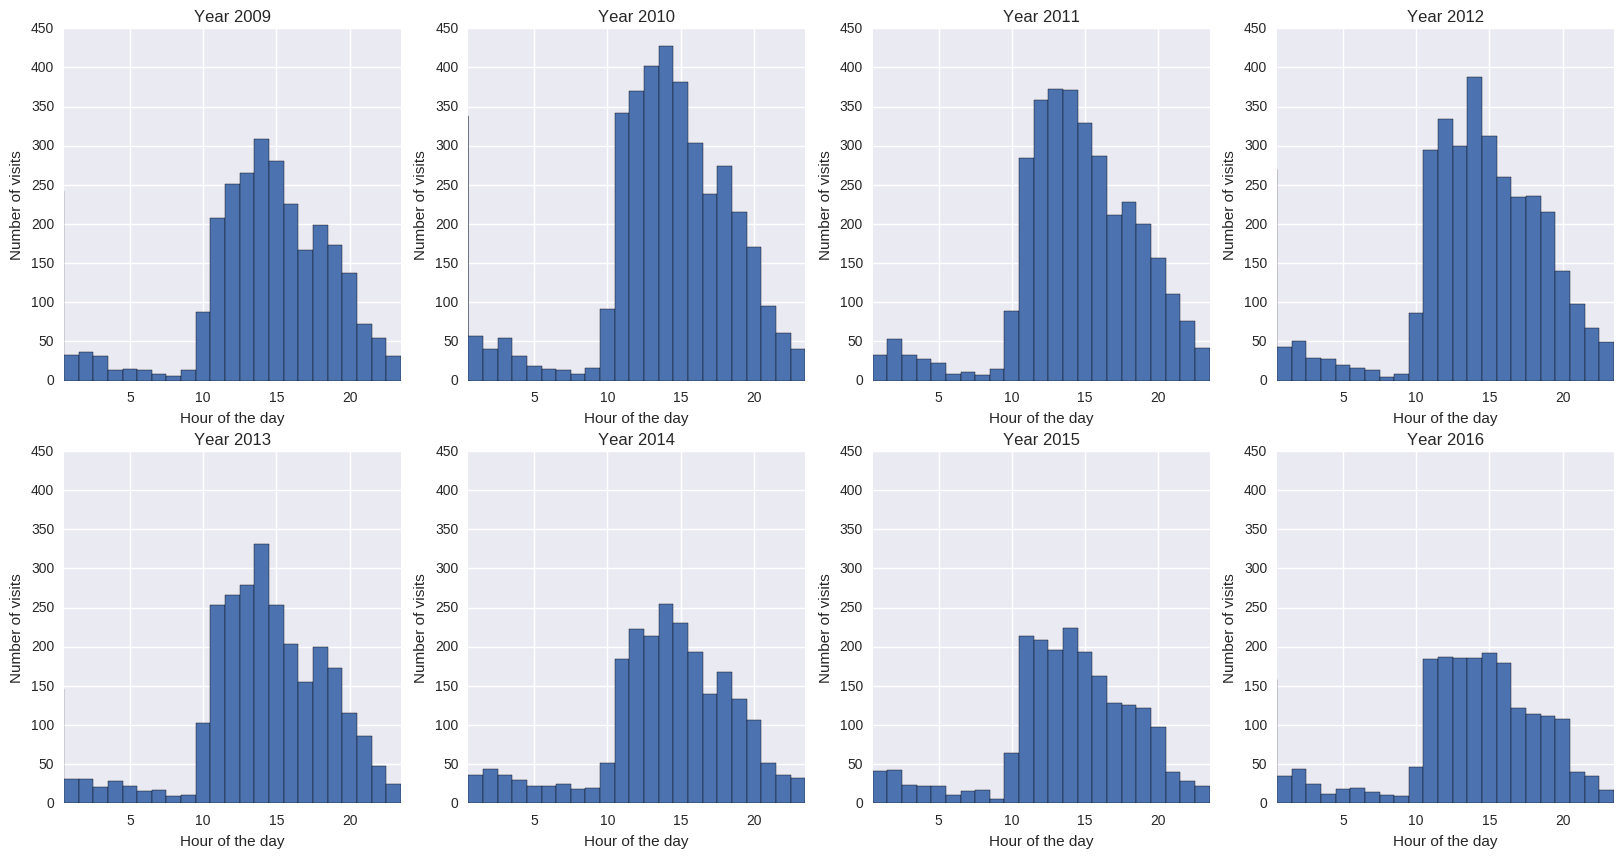

In [14]:
plt.figure(figsize=(20,10))
for i, year in enumerate(range(2009,2017)):
        plt.subplot(2,4,i+1)
        plt.title("Year %s" % year)
        df[df.visit_date.dt.year==year].visit_date.dt.hour.hist(bins = np.arange(25)-0.5)
        plt.xlim(0.5,23.5)
        plt.ylim(0,450)
        plt.xlabel("Hour of the day")
        plt.ylabel("Number of visits")
plt.show()

If clients mostly go at *working hours* on *working days*, does it mean that in *summer* (and thus, vacation time) there are less visits?

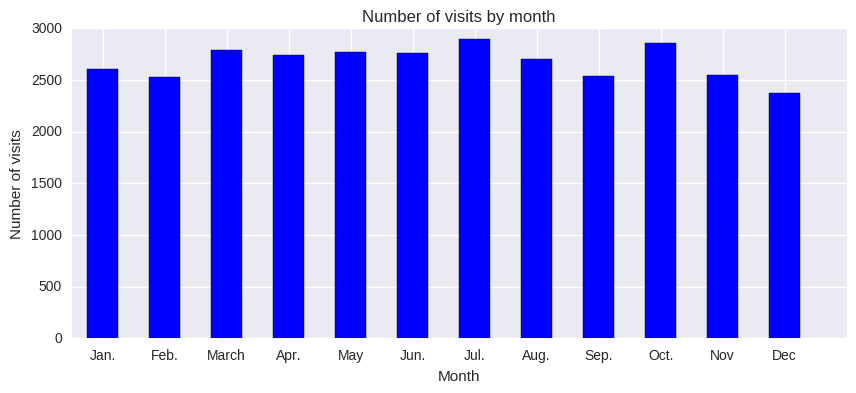

In [15]:
plt.figure()
times = pd.to_datetime(df.visit_date)
df_month = df.groupby(times.dt.month).size()
ax = df_month.plot(kind="bar")
plt.xlim(-0.5,12)
plt.title("Number of visits by month")
plt.xticks(rotation='horizontal')
months = ["Jan.","Feb.","March","Apr.","May","Jun.","Jul.","Aug.","Sep.","Oct.","Nov","Dec"]
ax.set_xticklabels(months)
plt.xlabel("Month")
plt.ylabel("Number of visits")

plt.show()

In [16]:
display(Markdown("""The drop in number of visits between the highest (**%s** visits in **%s**) and the lowest (**%s** visits in **%s**) months is just **%s**, a small but *noticeable* value. It's remarkable that the highest value is achieved in **July**, in the middle of the summer, while the lowest value falls in winter (probably because of *Christmas*).""" %  (df_month.max(), months[df_month.argmax()-1], df_month.min(), months[df_month.argmin()-1], "%.d%%" % ((df_month.max()-df_month.min())*1.0/df_month.max()/0.01)) ))


The drop in number of visits between the highest (**2892** visits in **Jul.**) and the lowest (**2378** visits in **Dec**) months is just **17%**, a small but *noticeable* value. It's remarkable that the highest value is achieved in **July**, in the middle of the summer, while the lowest value falls in winter (probably because of *Christmas*).

Lastly, let's see if the number of visits are constant throughout the month. If there are more visits at the beginning of the month than at the end, it would indicate that the clients are sensitive to the payday. *A priori* I believe that is not the case. Let's see the data:

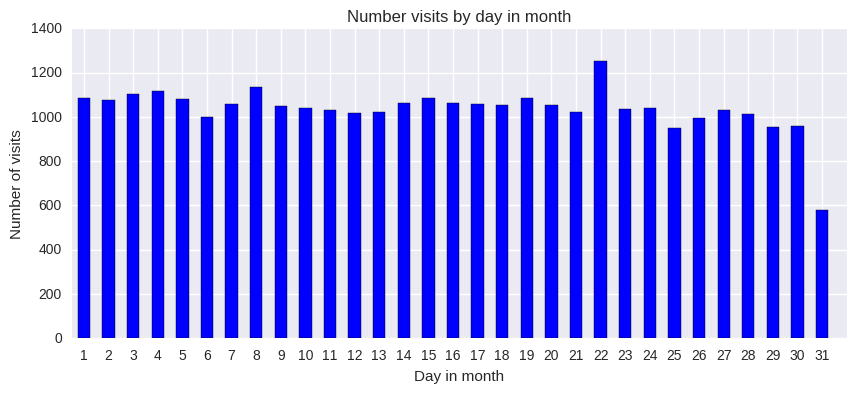

In [17]:
plt.figure()
times = pd.to_datetime(df.visit_date)
df_day_month = df.groupby(times.dt.day).size()
ax = df_day_month.plot(kind="bar")
plt.xlim(-0.5,31)
plt.title("Number visits by day in month")
plt.xlabel("Day in month")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of visits")
plt.show()

In [18]:
display(Markdown("""After ignoring the **31st** (and maybe also the **30**, because of *February*), there seems to be a slight decreasing slope between the **1st** (**%s** visits) and the **29th** (**%s** visits). That means a drop of **%s**.""" %  (df_day_month[1], df_day_month[29], "%.d%%" % ((df_day_month[1]-df_day_month[29])*1.0/df_day_month[1]/0.01)) ))

After ignoring the **31st** (and maybe also the **30**, because of *February*), there seems to be a slight decreasing slope between the **1st** (**1086** visits) and the **29th** (**955** visits). That means a drop of **12%**.

>[*Note for the mathematically inclined reader*]: In order to carry out a significance analysis we would need to make further hypothesis about the rate of the arrival of clients. A first approach would be to model the number of clients in a given day as a Poisson process (with lambda estimated on the first half of the year), and then calculate the probability of getting the results of the second half, knowing that the process is controlled by said Poisson process. This is left as an exercise to the reader since such a proof is out of the scope of this report.

## How *many* go to escorts?

Let's see if the escort market is dominated by a handful of *very* active clients, or if many people try a few times along their lives. Next graph shows the number of visits *per client*. As before, since *Punternet.com* is anonymous, the *actual* number of visits may be **larger**, if the same user posted from multiple accounts.

In order to make the following graph, all clients have been sorted *by number of visits* along the *horizontal axis*. Then, for each client, the height of the line shows his number of visits.

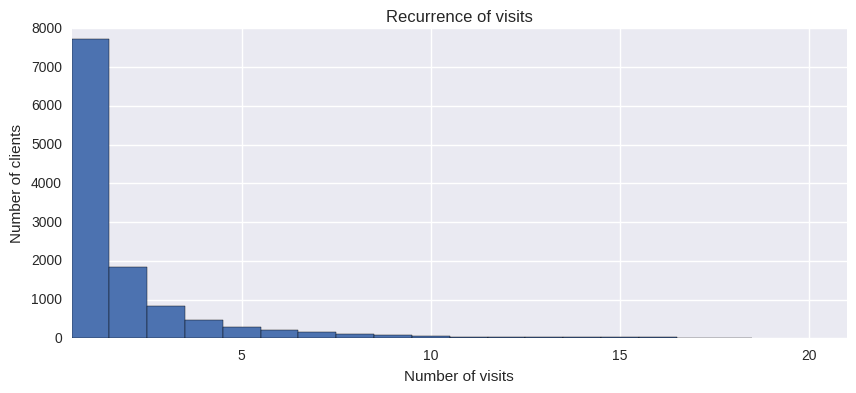

In [19]:
#plt.figure(figsize=(15,8))
visits_client = df.groupby("username").author_link.count().sort_values(ascending=False)
visits_client_old_index = copy(visits_client.index)
visits_client.hist(bins = np.arange(0,20,1)-0.5)
username = visits_client_old_index[0]

#plt.plot([0,len(visits_client)], [visits_client.median()]*2,linestyle='dashed', c='r', label="Median visits per client(%.2f)" % (visits_client.median()))
#plt.yticks(list(plt.yticks()[0]) + [visits_client.median()])
plt.legend()


plt.title("Recurrence of visits")
plt.xlabel("Number of visits")
plt.xlim((0.5,21))
plt.ylabel("Number of clients")
plt.show()

 As normal, most people have low values and there are small groups with a high value (as with *income* and *number of visits*). The most common value if **1** visit.

In [20]:
display(Markdown("* **Top 10%%** punters made more than **%d** visits\n" % (visits_client.quantile(0.9))))
display(Markdown("* **Top 1%%** punters made more than **%d** visits\n" % (visits_client.quantile(0.99))))
display(Markdown("* **Most profilif** punter made **%d** visits\n" % (visits_client.max())))


* **Top 10%** punters made more than **5** visits


* **Top 1%** punters made more than **22** visits


* **Most profilif** punter made **213** visits


Wow! Who's this guy that made **213** visits? Let's find out...

In [21]:
display(Markdown("""
His *nickname* is **%s**. He seems to have spent **&#163;%s** so far in *at least* **%d different girls**. 

Let's look at how many times he went with each one (the rest are unknown):
"""% (visits_client.index[0], "{:,}".format(int(df[df.username==username].amount_paid.sum())), df[df.username==username].id_service_provider.unique().shape[0] )))


g = df[df.username==username].groupby("name").username.count() 
girl_id="Indian Palace"


His *nickname* is **COLL**. He seems to have spent **&#163;13,409** so far in *at least* **10 different girls**. 

Let's look at how many times he went with each one (the rest are unknown):


In [22]:
g = df[df.username==username].groupby("name").author_link.size()
g =g[g.index>0]
g.sort_values(inplace=True,ascending=False)
g.index.name = "Lady"
g.name = "Number of visits"
name = g.index[0]
displaySeries(g)

Lady,Number of visits
Indian Palace,12
Covent Garden Girls,4
VIP Massage,1
Stunning Indian Sonam - Highly Recommended,1
Sara-100% Independent Escort,1
Chantelle,1
Anjali,1
Amira Pretty Indian,1


In [23]:
display(Markdown("Who is this **%s** he visited **%d** times?" % (girl_id, g[girl_id])))

Who is this **Indian Palace** he visited **12** times?

In [24]:
tmp = df.set_index("name", inplace=False)
a = tmp[tmp.index==name].lady_description.head()
pd.set_option('max_colwidth', 1000)
displaySeries(a, width=100)

name,lady_description
Indian Palace,Sara is a young punjabi girl in her early 20s and although she claimed to be Hindu....she had the lo...
Indian Palace,"Young 20?s, striking indian girl from Birmingham. Slim sexy figure and a very nice face. Shes a very..."
Indian Palace,"Sara is a sexy fair skinned Indian babe, 5' 5"" & athletic, wavy long hair, perfectly shaped cup C bo..."
Indian Palace,Pretty Anglo-Indian girl
Indian Palace,Sara is apparently 21 and studying for a sociology degree. Sara's pictures on the site do not do her...


In [25]:
display(Markdown("Seems to be an Indian lady named **Sara**, who worked **%d** times with **%d** different clients. Here is her profile:" % ((df.name==girl_id).sum(),df[df.name==girl_id].author_link.unique().shape[0])))

Seems to be an Indian lady named **Sara**, who worked **208** times with **112** different clients. Here is her profile:

In [26]:
displayDataFrame(df_providers[df_providers.name==name][['about', 'age', 'category', 'location', 'name']])

about,This profile has expired.
age,nan
category,Service Provider Category: Agency/Parlour Profile Type: Company
location,"Central London, Bayswater W2"
name,Indian Palace


In [27]:
display(Markdown("""
It seems an expired profile. Well, that's odd considering that her last review was on **%s**. It should be noted that it is also an **agency**, not a single lady.
Anyway, why is this profile *abandoned*? It seems to be the preferred place of a good customer. Maybe it's not so good *overall*? Let's see the global ranking by month. 
"""% (df[df.name==girl_id].visit_date.max().strftime('%A %B %-d %Y at %H:%M') )))


It seems an expired profile. Well, that's odd considering that her last review was on **Friday September 30 2016 at 23:00**. It should be noted that it is also an **agency**, not a single lady.
Anyway, why is this profile *abandoned*? It seems to be the preferred place of a good customer. Maybe it's not so good *overall*? Let's see the global ranking by month. 


To make the following graph, ladies have been sorted according to the number of visits per month and distributed along the *horizontal axis*. Then, for each lady, the height of the line shows her exact number of *clients per month*.

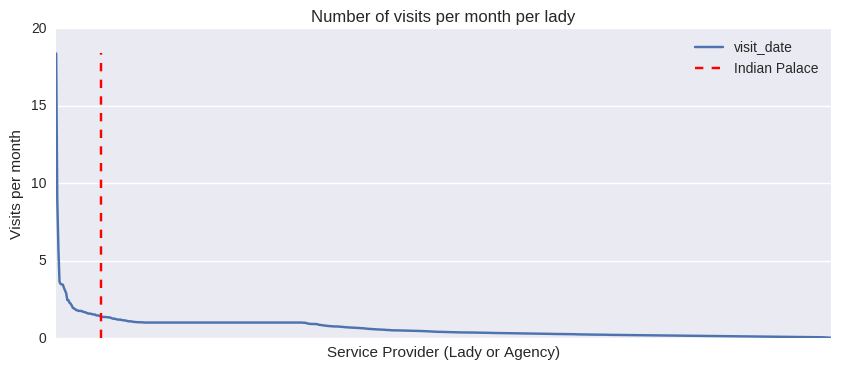

In [28]:
first_visit_by_lady = df.groupby("name").visit_date.min()
last_visit_by_lady = df.groupby("name").visit_date.max()
number_of_working_months_per_lady = (last_visit_by_lady- first_visit_by_lady).astype('timedelta64[s]')/86400./30.0 + 1.0
number_of_total_visits = df.groupby("name").visit_date.count()
visit_per_month_lady = (number_of_total_visits/number_of_working_months_per_lady).sort_values(ascending=False)
visit_per_month_lady = visit_per_month_lady[visit_per_month_lady<100]
visit_per_month_lady = visit_per_month_lady[visit_per_month_lady>0]
visit_per_month_lady = visit_per_month_lady[visit_per_month_lady.index!=-1]


#visit_per_month_lady.index = map(lambda v : "%d" % v,visit_per_month_lady.index)
visit_per_month_lady.sort_values(ascending=False, inplace=True)


visit_per_month_lady.plot(xticks=[])
plt.plot([list(visit_per_month_lady.index).index(name)]*2, [0.0, visit_per_month_lady.max()],linestyle='dashed', c='r', label="Indian Palace")
plt.legend()

plt.title("Number of visits per month per lady")
plt.xticks(rotation='vertical')
plt.ylabel("Visits per month")
plt.xlabel("Service Provider (Lady or Agency)")
plt.show()

The *dashed red line* shows the position of **Indian Palace**, which is among the *Top performers*.
That's *really* odd. Maybe there's a reason why they let their profile *expire*, but probably it wouldn't hurt to keep it updated.

Let's analyze now the most active ladies/clubs

In [29]:
visits_by_provider = df[df.name!=-1].groupby("name").size().sort_values(ascending=False).head()
visits_by_provider.index.name = "Lady"
visits_by_provider.name ="Number of Visits"
displaySeries(visits_by_provider)

Lady,Number of Visits
Sandy's Superstars,3233
Annabellas MK,1527
House Of Divine,772
Arabesque,646
Max's Angels,505


Interestingly there seems to be two *large* providers with more than 1000 reviews.

First one:

In [30]:
most_active_providers = visits_by_provider.index
first = df_providers[df_providers.name==most_active_providers[0]]
display(displayDataFrame(first[['name','about', 'category','location','phone']], width=100))

name,Sandy's Superstars
about,This limited profile was automatically created as a result of reviews being submitted. If you are th...
category,Service Provider Category: Agency/Parlour Profile Type: Company
location,Manchester
phone,01619029902


It doesn't seem to give much information, other than it's a **Mancherster** agency named **Sandy's Superstars**. The name implies multiple ladies and thus it's normal to have such a high number of visits.

Let's take a look at the second one:

In [31]:
second = df_providers[df_providers.name==most_active_providers[1]]
pd.set_option('max_colwidth', 100)
display(displayDataFrame(second[['name','about', 'category','location','rate_text', 'number_of_pictures', 'tags', 'website']], width=100))

name,Annabellas MK
about,"Whether you're a local to Milton Keynes or a visitor, Annabella's is worth the trip! Our Milton Key..."
category,Service Provider Category: Agency/Parlour Profile Type: Company
location,Milton Keynes
rate_text,20min 'Quicky'—£50 30min - fully inclusive—£60 45min - fully inclusive—£90 60min - fully...
number_of_pictures,20
tags,"[u'Assisted Bath/Shower', u'Breast Relief', u'Domination - Mild', u'Domination - Severe', u'Face Sit..."
website,http://www.annabellasescorts.com/home.php


Now this one seems more interesting. As expected, it's also an **agency** and with a fairly complete profile. It's located in **Milton Keynes**.

Now that we have these two let's compare some relevant metrics, like *income distribution* and *satisfaction* of clients. Both are expected to be *high*, but let data speak for itself.

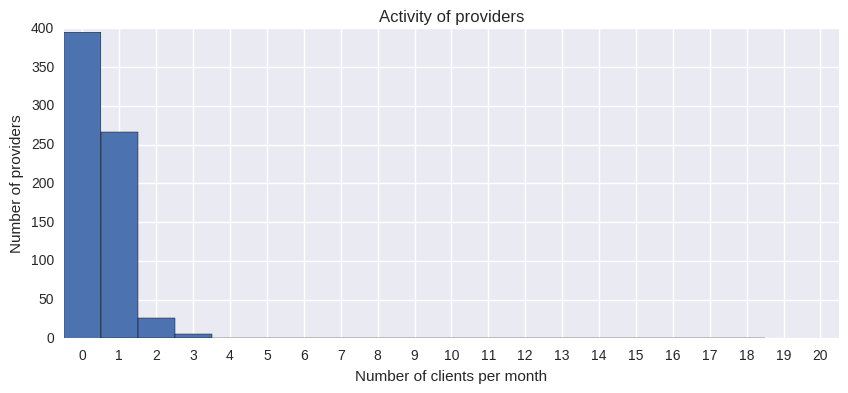

In [114]:
ax = visit_per_month_lady.hist(bins=np.arange(0,20,1)-0.5)
#plt.plot([0,len(visit_per_month_lady)], [visit_per_month_lady.median()]*2,linestyle='dashed', c='r', label="Median visits per month (%.2f)" % (visit_per_month_lady.median()))
#plt.yticks(list(plt.yticks()[0]) + [visit_per_month_lady.median()])
plt.legend()

ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
plt.title("Activity of providers")
plt.xlabel("Number of clients per month")
plt.xlim(-0.5,20.5)
plt.xticks(rotation='horizontal')
plt.ylabel("Number of providers")
plt.show()

This graph shows that *most* of the providers have **one single review** per month. Of course, not all clients leave *review*, so this graph shouls be read with an *at least* in mind. 

In [33]:
table = [ ['Top %', 'Visits per month'],
        ['Best' , visit_per_month_lady.max()],
        ['Top 0.1%', visit_per_month_lady.quantile(0.999)],
        ['Top 1%', visit_per_month_lady.quantile(0.99)],
        ['Top 2%', visit_per_month_lady.quantile(0.98)],
        ['Median (50%)', visit_per_month_lady.quantile(0.5)]
        ]
displayTable(table)

Top %,Visits per month
Best,18.36
Top 0.1%,11.78
Top 1%,3.24
Top 2%,2.11
Median (50%),0.40


Indeed the difference between the **0.1%** and the rest is extremely large. Who are those ladies? Or maybe are they agencies?

In [34]:
visit_per_month_lady.name = "Visits per month"
visit_per_month_lady.index.name = "Lady id"
displaySeries(visit_per_month_lady.head(5))

Lady id,Visits per month
Sandy's Superstars,18.36
Annabellas MK,8.90
House Of Divine,5.76
Arabesque,3.63
Ego Massage,3.49


They are the same as in the previous graph. The first one, **Id 13521** is the **Manchester** agency named **Sandy's Superstars**. They don't have a profile on the site *yet*, but data points that they should *really* create one *and* keep it updated.

## Cost. Price. Income. Let's talk about money.

### Income per visit

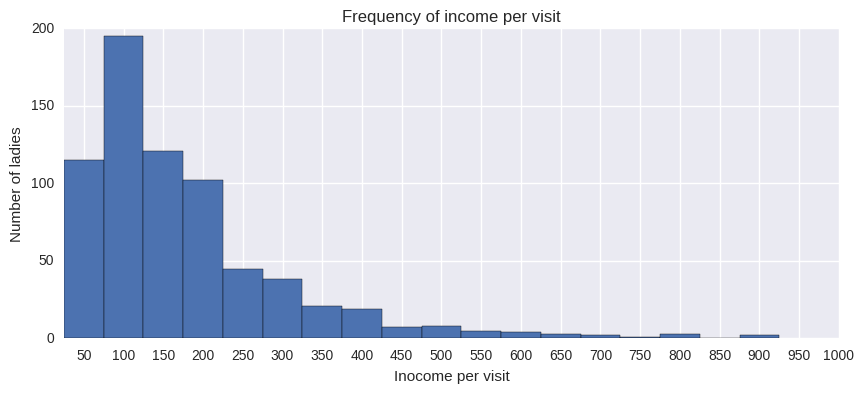

In [105]:
plt.figure()
earnings_per_visit = (df[df.name!=-1].groupby("name").amount_paid.sum()/df[df.name!=-1].groupby("name").amount_paid.count()).sort_values(ascending=False)
plt.title("Frequency of income per visit")
ax = earnings_per_visit.hist(bins = np.arange(0,1000,50)-25)

plt.xlim((25,1000))
plt.xlabel("Inocome per visit")
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=50.0))
plt.ylabel("Number of ladies")
plt.show()

As shown in the graph, most ladies earn around **&#163;100** per visit. The Top 1% performers earn most of the money in the industry, while the median income is not particularly high.

Let's look at the numbers:

In [36]:
table = [ ['Top %', 'Income per visit'],
        ['Best' , earnings_per_visit.max()],
        ['Top 1%', earnings_per_visit.quantile(0.99)],
        ['Top 2%', earnings_per_visit.quantile(0.98)],
        ['Top 3%', earnings_per_visit.quantile(0.97)],
        ['Median (50%)', earnings_per_visit.quantile(0.5)]
        ]
displayTable(table)

Top %,Income per visit
Best,2296.25
Top 1%,900.42
Top 2%,674.63
Top 3%,569.92
Median (50%),141.82


In [37]:
display(Markdown("""
Now it's clear that **the Top 1%% earns a %d%% more than the median lady**.
For info, *the top earner per visit* is **%s** from **%s**.
""" % ((earnings_per_visit.quantile(0.99)-earnings_per_visit.quantile(0.5))*100/earnings_per_visit.quantile(0.5), 
       df[df.name==earnings_per_visit.argmax()].name.iloc[0], 
        df[df.name==earnings_per_visit.argmax()].location.iloc[0] )))


Now it's clear that **the Top 1% earns a 534% more than the median lady**.
For info, *the top earner per visit* is **Elegant Escort Agency** from **Nottingham**.


On a *micro* level, let's view the income distribution for *both* the **top performer** and the **second best**.

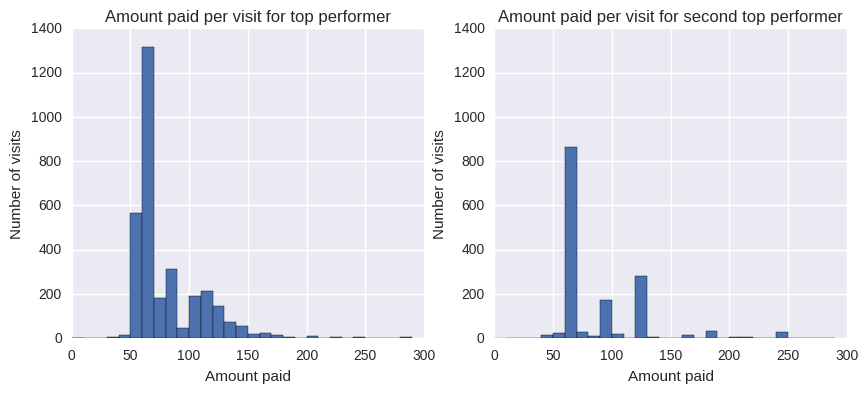

In [38]:
plt.figure()
plt.subplot(121)
plt.title("Amount paid per visit for top performer")
df[df.name==most_active_providers[0]].amount_paid.hist(bins = np.arange(0,300,10))
plt.xlabel("Amount paid")
plt.ylabel("Number of visits")

plt.subplot(122)
plt.title("Amount paid per visit for second top performer")
df[df.name==most_active_providers[1]].amount_paid.hist(bins = np.arange(0,300,10))
plt.xlabel("Amount paid")
plt.ylabel("Number of visits")
plt.ylim((0,1400))
plt.show()

The most common price seems to be slightly above **&#163;50** *per visit*, with a long tail of high paying clients.

We can go a step further and analyze the income *per hour*, instead of *per visit*. Although the author does not find this metric particularly interesting (and even misleading), since extremely short services (or even those for where the user filled with a *zero*) give inflated values. To account for that **only visit longer than 30 minutes have been considered**.

### Income per hour

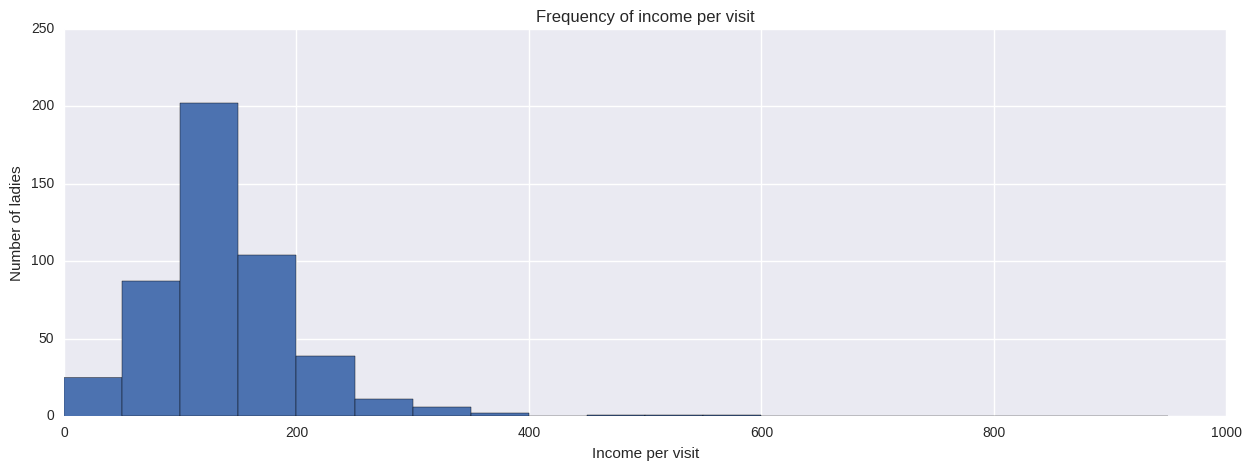

In [123]:
plt.figure(figsize=(15,5))
df2 = df[df.duration_visit_minutes>=30]

earnings_per_hour = (df2.groupby("name").amount_paid.sum()/df2.groupby("name").duration_visit_minutes.sum()).sort_values(ascending=False)*60.0
earnings_per_hour.hist(bins=np.arange(0,1000,50))

plt.title("Frequency of income per visit")
plt.xlabel("Income per visit")
plt.ylabel("Number of ladies")
plt.show()

We can repeat the table above to view the distribution of income *per hour*

In [124]:
table = [ ['Top %', 'Income per hour'],
        ['Best' , earnings_per_hour.max()],
        ['Top 1%', earnings_per_hour.quantile(0.99)],
        ['Top 2%', earnings_per_hour.quantile(0.98)],
        ['Top 3%', earnings_per_hour.quantile(0.97)],
        ['Median (50%)', earnings_per_hour.quantile(0.5)]
        ]
displayTable(table)

Top %,Income per hour
Best,3125.00
Top 1%,1204.03
Top 2%,531.02
Top 3%,331.30
Median (50%),131.62


In [41]:
display(Markdown("""
Compared to the previous table (*income per visit*) here the values are sensibly larger. In particular, the top earner *per hour* is larger than the top earner *per visit*. For info, *the top earner per visit* is **%s** from **%s**.
""" % (df2[df2.name==earnings_per_hour.argmax()].name.iloc[0], df2[df2.name==earnings_per_hour.argmax()].location.iloc[0]) ))


Compared to the previous table (*income per visit*) here the values are sensibly larger. In particular, the top earner *per hour* is larger than the top earner *per visit*. For info, *the top earner per visit* is **Exquisite Cristal** from **North West/Manchester**.


### Cost of visit at different times

Let's see if some hours of the day are more *expensive* than others.

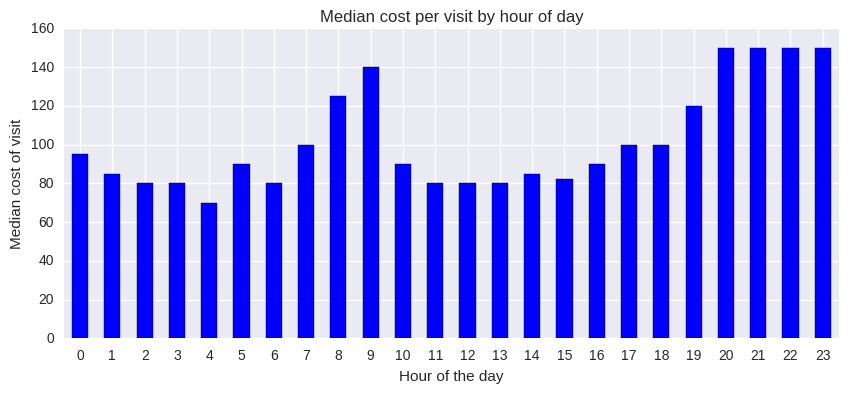

In [116]:
plt.figure()
times = pd.to_datetime(df.visit_date)
df.groupby(times.dt.hour).amount_paid.median().plot(kind="bar")
plt.xlim(-0.5,23.5)
plt.title("Median cost per visit by hour of day")
plt.xticks(rotation='horizontal')
plt.xlabel("Hour of the day")
plt.ylabel("Median cost of visit")
plt.show()

It seems that they *might* be. Notice how the more expensive hours are those with *very few* visits according to the first graph (see above), so that might very well be **statistical noise** (and thus not a proof of anything). That is the case for **8:00-9:00 a.m**. 

For hours in the evening, around **20:00**, this surge in price indicates that visits starting at that time or later include **all-night**, longer services.

We saw before that most visits take place on workdays. But what happens with their **price**? Is it the same every day of the week?

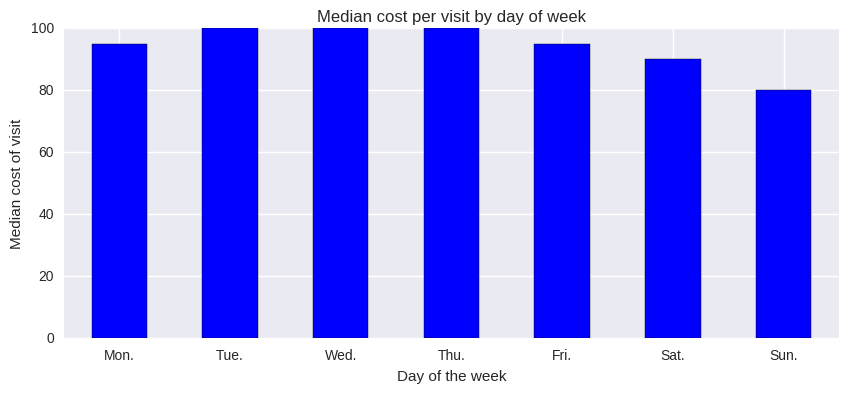

In [117]:
plt.figure()
times = pd.to_datetime(df.visit_date)
df_weekdays = df.groupby(times.dt.weekday).amount_paid.median()
ax = df_weekdays.plot(kind="bar")
plt.xlim(-0.5,6.5)
plt.title("Median cost per visit by day of week")
plt.xticks(rotation='horizontal')
tmp = ["Mon.","Tue.","Wed.","Thu.","Fri.","Sat.","Sun."]
ax.set_xticklabels(tmp)
plt.xlabel("Day of the week")
plt.ylabel("Median cost of visit")
plt.show()

In [44]:
display(Markdown("""
Weekends are slightly more economical, being the lowest on **Sunday** a **%d%%** cheaper than the most expensive, **Tuesday-Thursday**.
""" % ((df_weekdays.max()-df_weekdays.min())/df_weekdays.max()/0.01, ) ))


Weekends are slightly more economical, being the lowest on **Sunday** a **20%** cheaper than the most expensive, **Tuesday-Thursday**.


Concerning the median price of a visit along the year, we get this:

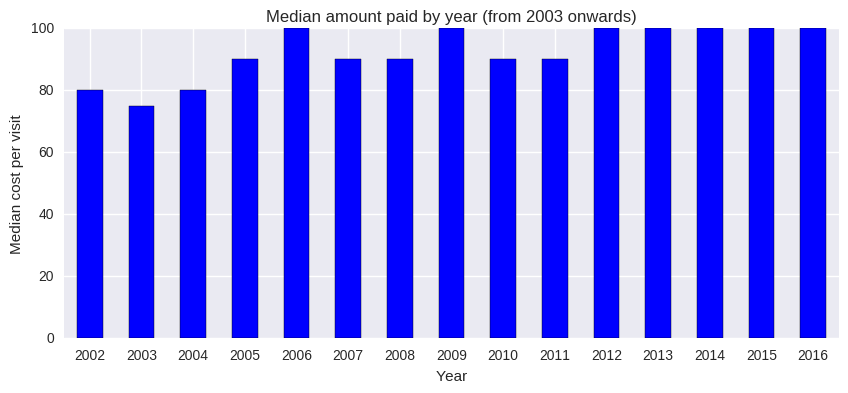

In [118]:
plt.figure()
by_year = df[df.visit_date>datetime.datetime(2003,1,1)].groupby(pd.Grouper(key='visit_date', freq='12M')).amount_paid.median()
ax = by_year.plot(kind='bar')
plt.title("Median amount paid by year (from 2003 onwards)")
plt.xlabel("Year")
plt.xticks(rotation='horizontal')
plt.ylabel("Median cost per visit")
ax.set_xticklabels(by_year.index.year-1)
plt.show()

Median cost passed from **&#163;80** in **2002** to **&#163;100** in 2016. Which doesn't seem to be higher than the inflation rate, according to the *Bank Of England*.
![Bank Of England Inflation Rate](data/escort/img/boe.png)

The next quesiton I answered was if the **number** of visits *and* the **cost** per visit are constant along the month. It seems to be so.

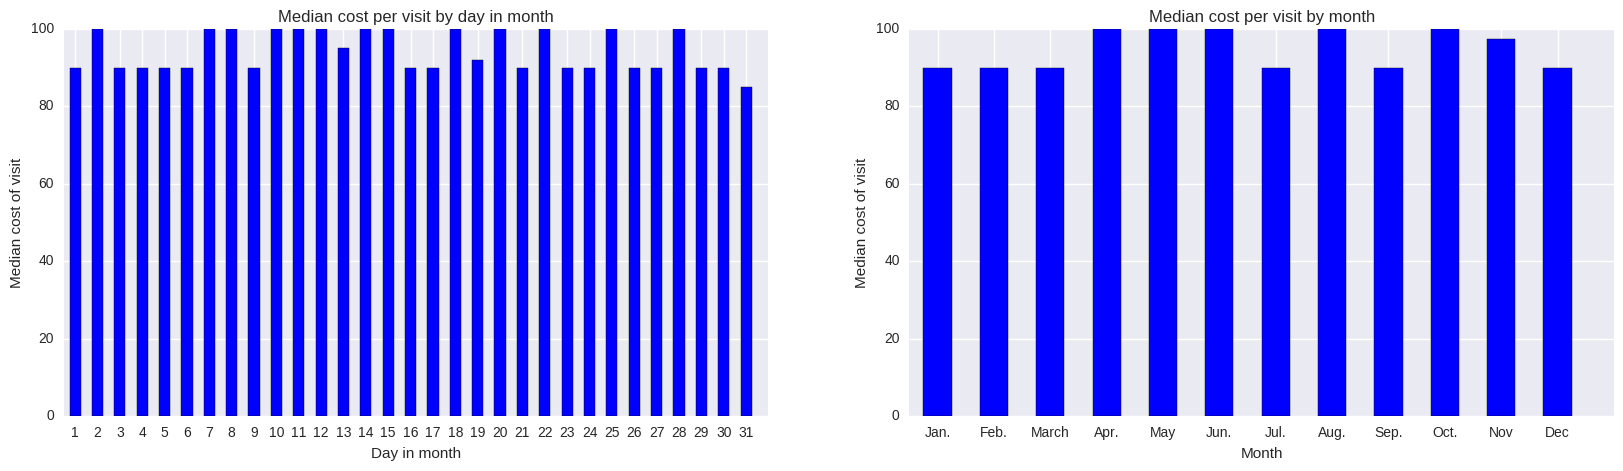

In [46]:
plt.figure(figsize=(20,5))
plt.subplot(121)
times = pd.to_datetime(df.visit_date)
ax = df.groupby(times.dt.day).amount_paid.median().plot(kind="bar")
plt.xlim(-0.5,31)
plt.title("Median cost per visit by day in month")
plt.xlabel("Day in month")
plt.xticks(rotation='horizontal')
plt.ylabel("Median cost of visit")

plt.subplot(122)

times = pd.to_datetime(df.visit_date)
ax = df.groupby(times.dt.month).amount_paid.median().plot(kind="bar")
plt.xlim(-0.5,12)
plt.title("Median cost per visit by month")
plt.xticks(rotation='horizontal')
tmp = ["Jan.","Feb.","March","Apr.","May","Jun.","Jul.","Aug.","Sep.","Oct.","Nov","Dec"]
ax.set_xticklabels(tmp)
plt.xlabel("Month")
plt.ylabel("Median cost of visit")

plt.show()

Next graph shows the median cost per visit for each location. In order to stabilize the results only locations with more than **10 visits** have been considered.

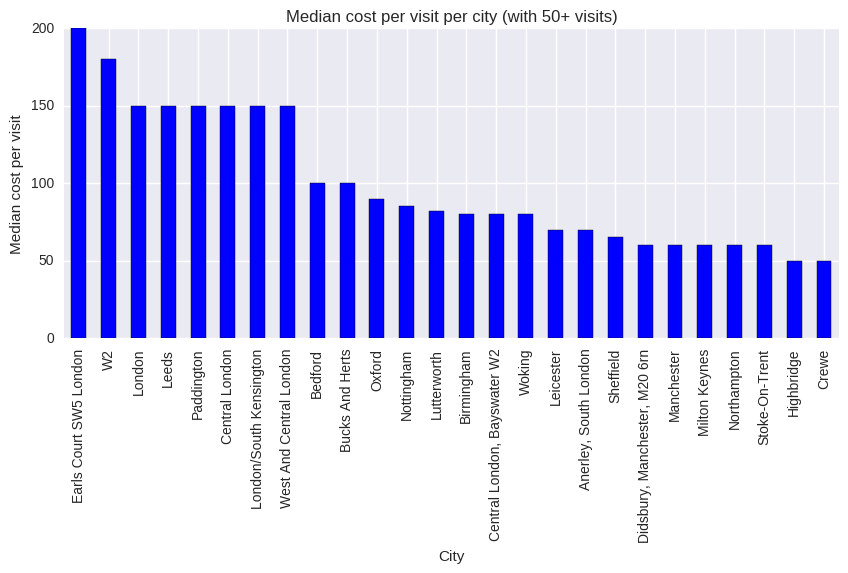

In [47]:
plt.figure()
g = df[df.visit_date.dt.year>2010].groupby("location")
g.filter(lambda e: len(e)>50).groupby("location").amount_paid.median().sort_values(ascending=False).plot(kind='bar', label="")

plt.title("Median cost per visit per city (with 50+ visits)")
plt.xlabel("City")
plt.ylabel("Median cost per visit")
plt.legend()
plt.show()

The most expensive area is **Earl's Court** district in **London**, with a representative price **&#163;200** *per visit*.

To conclude, in order to give an impression of the **amount of money** this industry moves *per year*, take a look at the following graph.

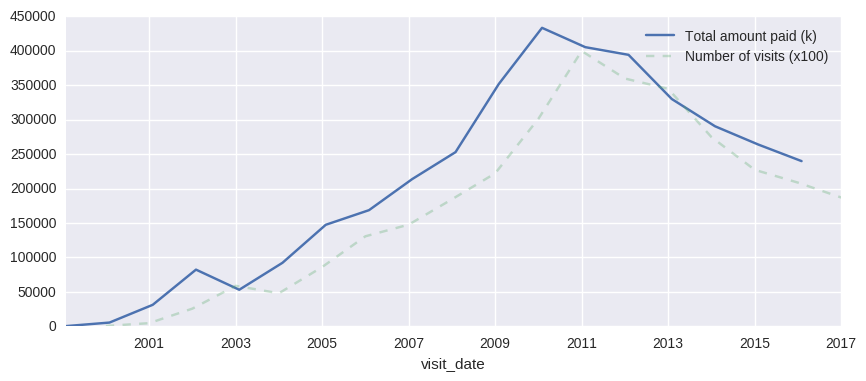

In [48]:
def sumClampToPct95(v):
        th = v.quantile(0.95)
        v[v>th]= th
        return v.sum()

plt.figure()
df.groupby(pd.Grouper(key='visit_date', freq='12M')).amount_paid.apply(sumClampToPct95).plot(label="Total amount paid (k)")
(df.groupby(pd.Grouper(key='visit_date', freq='12M')).size()*100).plot(label="Number of visits (x100)", alpha=0.3, linestyle='dashed')

plt.legend()
plt.show()

This graph shows, naturally, the total amount of money paid by the people *who post reviews* in the site. It is, then, a fraction of the **actual value**. In any case, during the *peak* in 2011 just the punters who shared their experience in Punternet.com spent more than **&#163;400,000** *per year*.

Be careful when over-analyzing this graph. The amount of money spent *as reported by Punternet.com* depend on the popularity of the site. Indeed, this graph is basically mirroring the number of visits to Punternet.com (dashed green line). 

## Satisfaction criteria

To analyze the satisfaction of the client is *tricky*. A first approach was to measure the *frequency of recommendation*. Unfortunately, this approach is too coarse for useful analysis. The client cannot say *so so recommended*, but either a full *yes/no*.
In order to increase the accuracy of *satisfaction* the text of the story has been run through a sentiment analyzer. These relatively novel techniques in Natural Language Processing have been nicely implemented by the [VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) project.

In [49]:
display(Markdown("""Each of the **%s** reviews has been analyzed and a score between **-1** (most negative) and **+1** (most positive) has been given.""" %  (len(df_reviews)) ))

Each of the **32115** reviews has been analyzed and a score between **-1** (most negative) and **+1** (most positive) has been given.

Then, the *average* satisfaction of all the visits for each price point has been plotted.

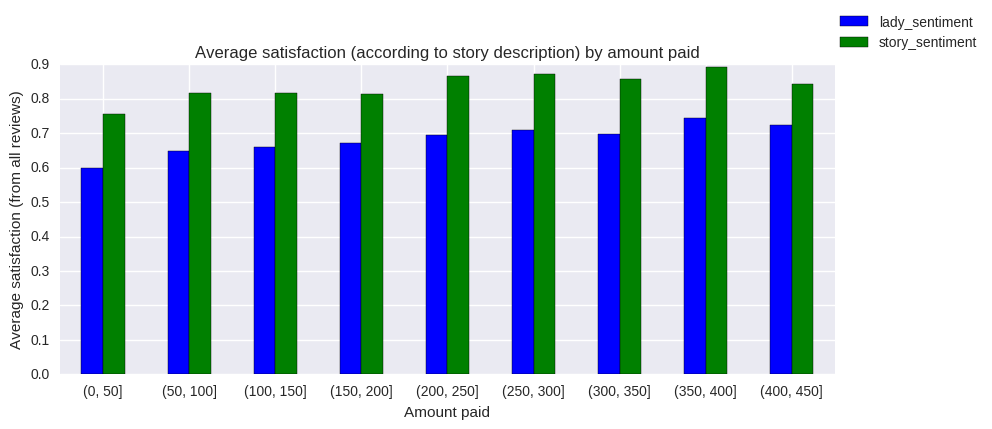

In [50]:
df.groupby(pd.cut(df.amount_paid, np.arange(0, 500,50)))[['lady_sentiment','story_sentiment']].mean().plot(kind='bar')
plt.legend(bbox_to_anchor=(1.2, 1.2))
plt.title("Average satisfaction (according to story description) by amount paid")
plt.xticks(rotation='horizontal')
plt.xlabel("Amount paid")
plt.ylabel("Average satisfaction (from all reviews)")
plt.show()

It seems to indicate that no clear correlation between price and satisfaction exists, except for that in the bottom range. In order to check for consistency let's plot the same graph, but with the average *recommendation*.

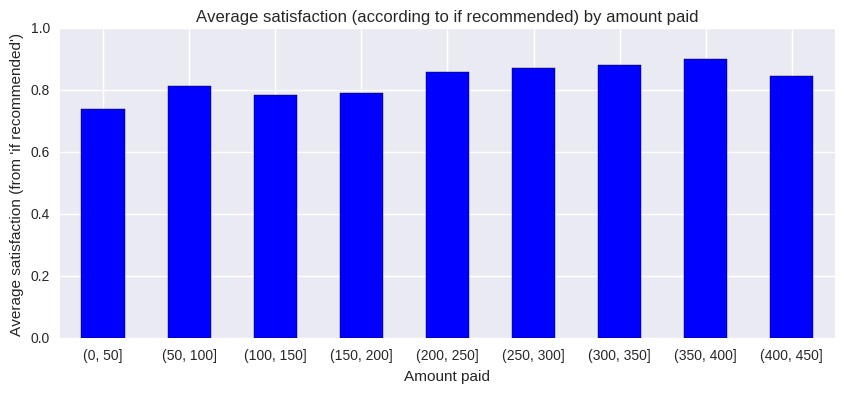

In [51]:
plt.figure()
df.groupby(pd.cut(df.amount_paid, np.arange(0, 500,50))).recommend.mean().plot(kind='bar')
plt.title("Average satisfaction (according to if recommended) by amount paid")
plt.xticks(rotation='horizontal')
plt.xlabel("Amount paid")
plt.ylabel("Average satisfaction (from 'if recommended')")
plt.show()

Both graphs seem consistent and confirm the fact that not more paying clients are necessarily more satisfied, but that **less paying customers are less satisfied**. Maybe an instance of *you get what you pay for?*, or that *cheap customers are the worst?*.

Going forward, how important are the *looks* of a lady respect to their behavior? In order to find out the sentiment of both *lady description* and *story description* has been analyzed.



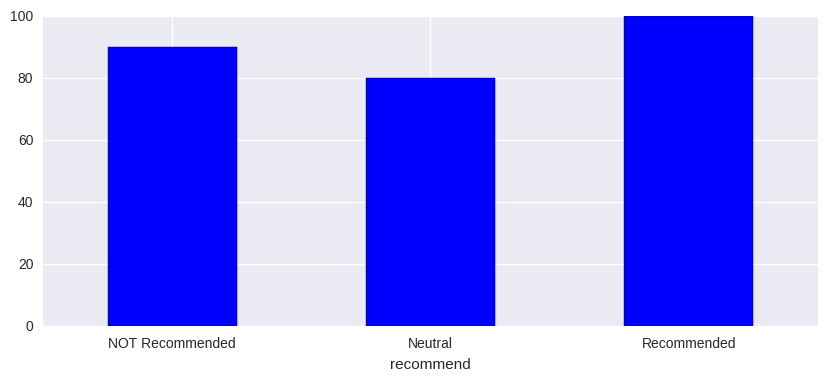

In [52]:
plt.figure()
ax = df.groupby("recommend").amount_paid.median().plot(kind='bar', tick_label=["NOT Recommended", "Neutal", "Recommended"])
ax.set_xticklabels(('NOT Recommended', 'Neutral', 'Recommended'))
plt.xticks(rotation='horizontal')
plt.show()


Another metric for success is the *number of visits per lady*. Since ladies longer in business had naturally more time to get more visits, the following graph shows the number of visits per lady *per month*.  

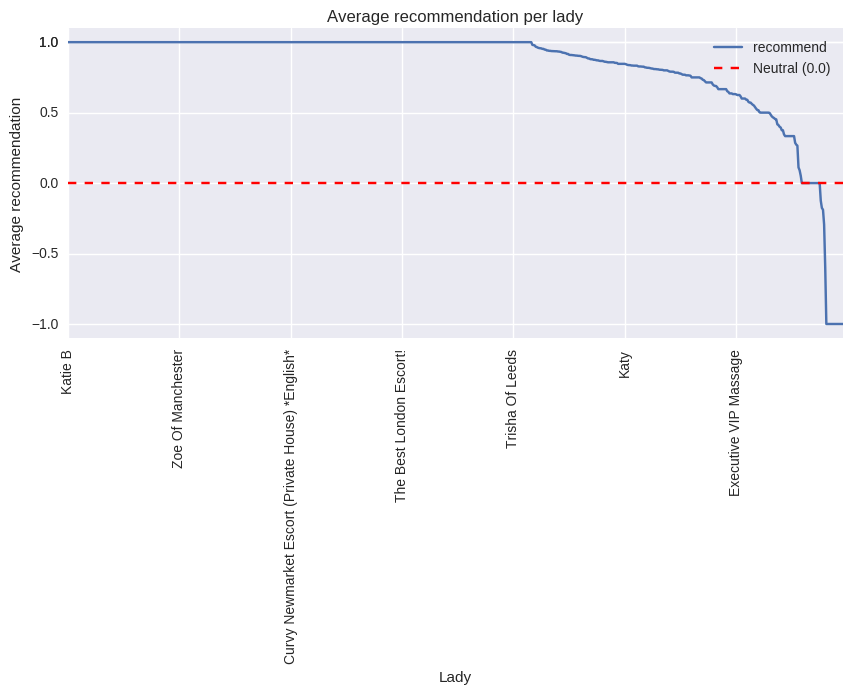

In [53]:
plt.figure()
mean_recommendation = df.groupby("name").recommend.mean()
visits_per_lady = df.groupby("name").recommend.count()



mean_recommendation = mean_recommendation[visits_per_lady>0].sort_values(ascending=False)
mean_recommendation.plot()
plt.plot([0,len(mean_recommendation)], [0]*2,linestyle='dashed', c='r', label="Neutral (0.0)")
plt.yticks(list(plt.yticks()[0]) + [mean_recommendation.median()])
plt.legend()


plt.title("Average recommendation per lady")
plt.xlabel("Lady")
plt.xticks(rotation='vertical')
plt.ylabel("Average recommendation")
plt.ylim((-1.1,1.1))
plt.show()

In [54]:
display(Markdown("""
A **80%%** of the ladies have a mean recommendation above **%.2f**, and a **60%%** of ladies have a **%d%%** of positive reviews.
""" % (mean_recommendation.quantile(0.20), 100*mean_recommendation.quantile(0.40))))


A **80%** of the ladies have a mean recommendation above **0.76**, and a **60%** of ladies have a **97%** of positive reviews.


## Analysis on veteranity

Now, who has been longer in business? That's *a question*

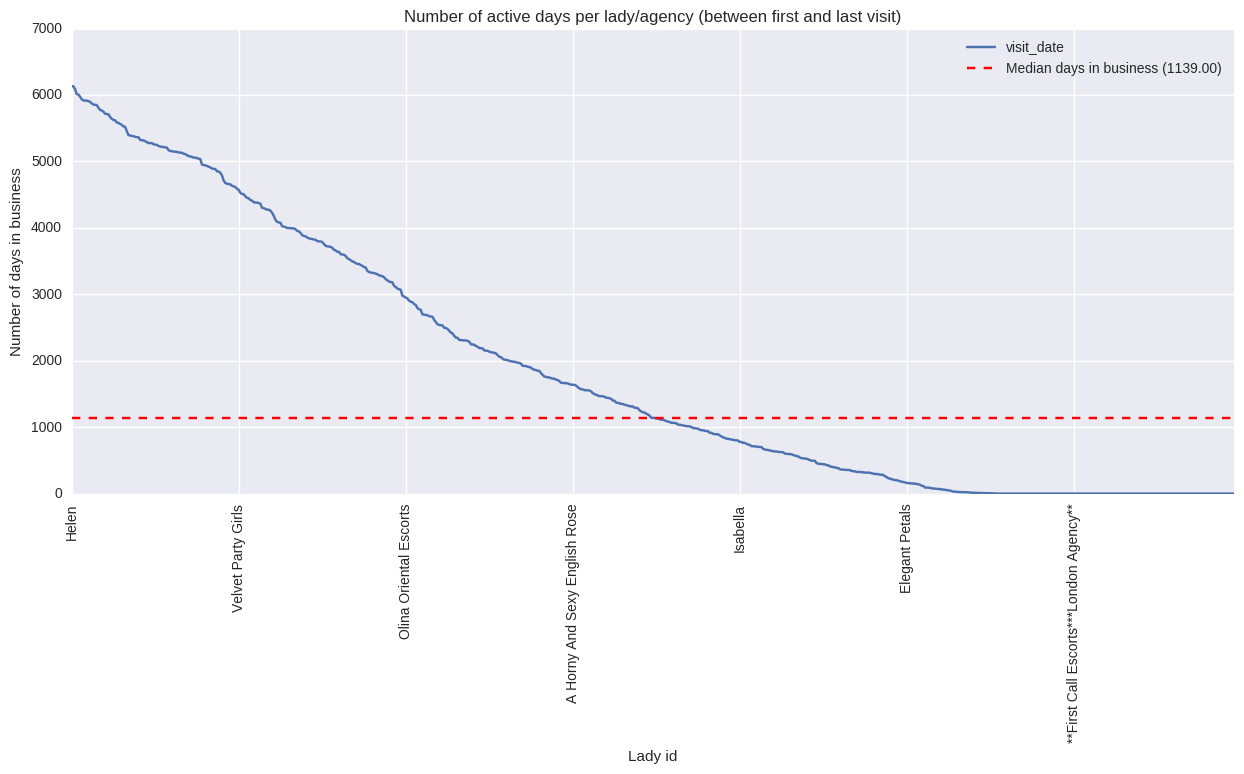

In [55]:
plt.figure(figsize=(15,6))
first_visit_by_lady = df.groupby("name").visit_date.min()
last_visit_by_lady = df.groupby("name").visit_date.max()
days_in_business_by_lady = (last_visit_by_lady-first_visit_by_lady).sort_values(ascending=False).astype('timedelta64[D]')
days_in_business_by_lady.plot()

plt.plot([0,len(days_in_business_by_lady)], [days_in_business_by_lady.median()]*2,linestyle='dashed', c='r', label="Median days in business (%.2f)" % (days_in_business_by_lady.median()))
#plt.yticks(list(plt.yticks()[0]) + [days_in_business_by_lady.median()])
plt.legend()


plt.title("Number of active days per lady/agency (between first and last visit)")
plt.xlabel("Lady id")
plt.xticks(rotation='vertical')
plt.ylabel("Number of days in business")
plt.show()

The question arises, are more ancient agencies able to charge more?

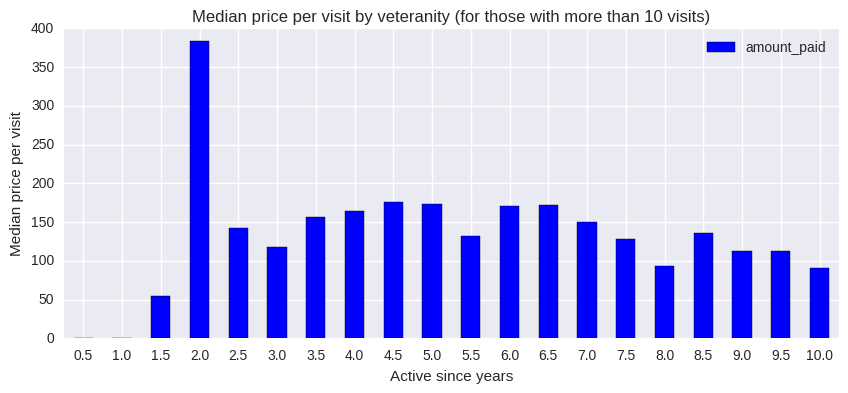

In [56]:
visits_per_lady = df.groupby("id_service_provider").size()
active_since_days_by_lady = (datetime.datetime.today()-df.groupby("id_service_provider").visit_date.min()).astype('timedelta64[D]')
active_since_days_by_lady= active_since_days_by_lady[visits_per_lady>10]
median_amount_paid_by_lady = df.groupby("id_service_provider").amount_paid.median()

tmp = pd.concat([active_since_days_by_lady,median_amount_paid_by_lady], axis=1)
tmp2 = tmp.groupby(pd.cut(tmp.visit_date, np.arange(0, 365*10,365/2)))[['amount_paid']].mean()
ax = tmp2.plot(kind='bar')
plt.title("Median price per visit by veteranity (for those with more than 10 visits)")
plt.xlabel("Active since years")
ax.set_xticklabels(["%.1f" % (1.0/365.0*float(v.split(", ")[1].split("]")[0])) for v in  list(tmp2.index)])
plt.xticks(rotation='horizontal')
plt.ylabel("Median price per visit")
plt.show()

There's no clear tendency. Newcomers **do not must charge less**.

## Analysis of profiles

We've seen above that some profiles have many pictures, while many other don't. How many profiles have picture?

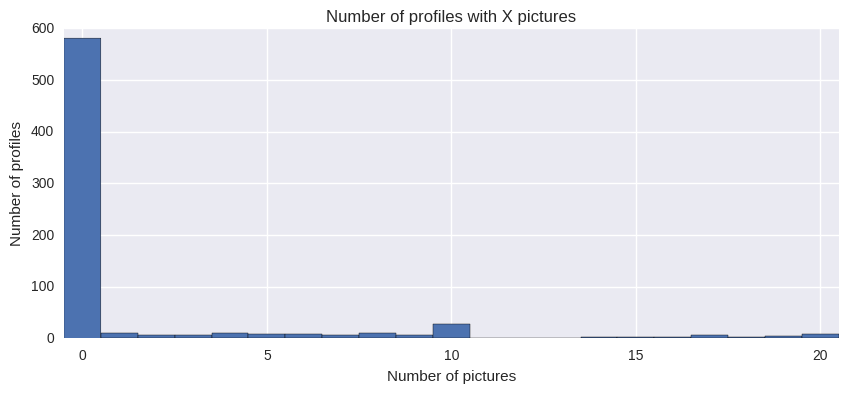

In [57]:
plt.figure()
df_providers.number_of_pictures.hist(bins = np.arange(0,22)-0.5)
plt.xlim((-0.5,20.5))
plt.title("Number of profiles with X pictures")
plt.xlabel("Number of pictures")
plt.ylabel("Number of profiles")
plt.show()

How, it seems to be dominated by profiles with *no* pictures. OK, let's focus only on profiles with at least *1* picture.

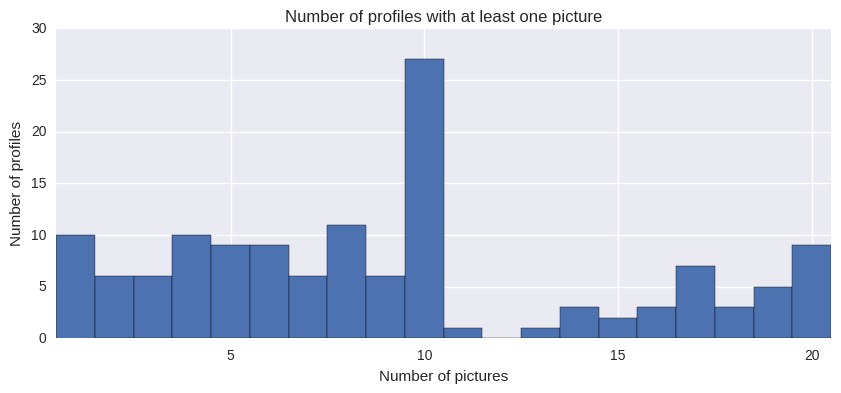

In [58]:
plt.figure()
df_providers.number_of_pictures.hist(bins = np.arange(1,22)-0.5)
plt.xlim((0.5,20.5))
plt.title("Number of profiles with at least one picture")
plt.xlabel("Number of pictures")
plt.ylabel("Number of profiles")
plt.show()

Now, that gives more information. There are profiles with 10 pictures. It's probably because it's a round number *"Hey kid put somethin' like 10 pics in the profil hmmmkay?"* thing. But... are they able to charge more?

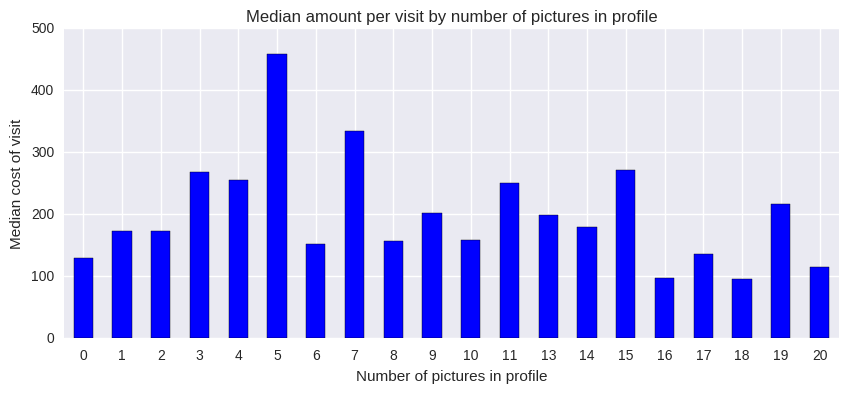

In [59]:
plt.figure()
ax = df.groupby("number_of_pictures").amount_paid.mean().plot(kind='bar')
plt.title("Median amount per visit by number of pictures in profile")
plt.xlabel("Number of pictures in profile")
ax.set_xticklabels([int(float(item.get_text())) for item in ax.get_xticklabels()])
plt.xticks(rotation='horizontal')
plt.ylabel("Median cost of visit")
plt.show()

And the answer is **no**.

# Analysis on preferences (or how I discovered what are *really* people into)

## Do gentlemen prefer blondes?

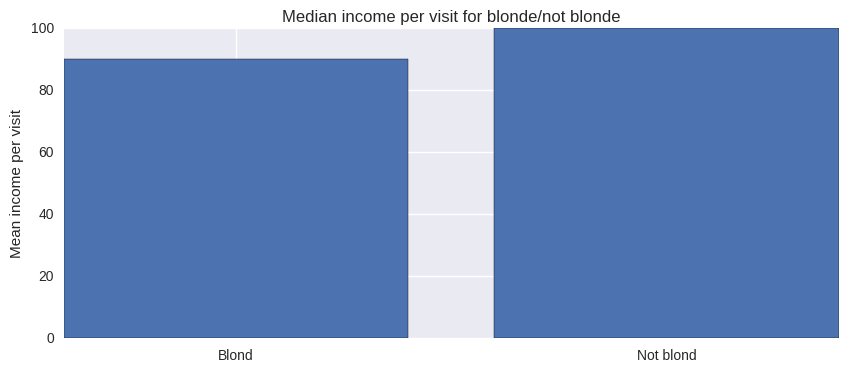

In [60]:
plt.figure()
blond_idx = (df.blond_count>0)
plt.bar([0,1], [df[blond_idx].amount_paid.median(), df[~blond_idx].amount_paid.median()], tick_label = ["Blond", "Not blond"], align = "center")
plt.title("Median income per visit for blonde/not blonde")
plt.ylabel("Mean income per visit")
plt.show()

It doesn't seem to matter (we'll get a confirmation below)

## What offers the market? An Introduction

In [61]:
tags_list = []
for i,t in df_providers.tags.iteritems():
        if type(t)==list:
                tags_list.extend(t)
c = Counter(tags_list).most_common()
displayTable([["Service", "Number of occurrences"]]+c[:10])

Service,Number of occurrences
Visits - Incall,131
Massage - Sensual,127
Intercourse - Vaginal,119
Kissing - French,118
Reverse Oral,117
Intercourse - Oral,116
Tie and Tease,111
Visits - Outcall,109
Lunch/Dinner Dates,108
Two-Girl Service,107


Well, nothing out of the common. Let's plot all of them.

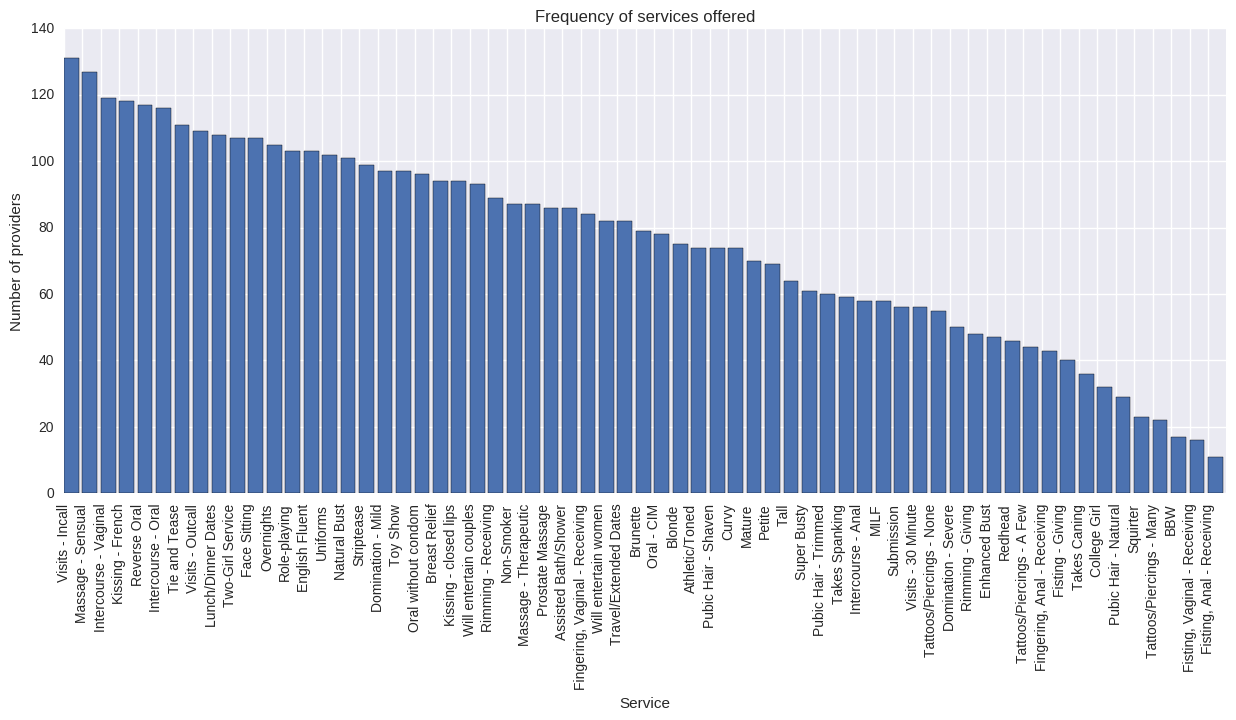

In [62]:
plt.figure(figsize=(15, 6))
plt.title("Frequency of services offered")
services, freqs = zip(*c)
plt.bar(np.arange(len(freqs)), freqs, tick_label=services)
plt.xticks(rotation='vertical')
plt.xlim((0,len(freqs)))
plt.xlabel("Service")
plt.ylabel("Number of providers")
plt.show()

This figure shows that not all services are *equally* popular. But it doesn't say whether these services are independent or not. For example, the graph shows that both *Fisting Anal* and *Fisting Vaginal* are not often advertised, but intuitively one would think that ladies willing to do the former would also be ready to perform the latter. Now, is this *hypothesis* backed by data?

To find out let's draw the map with the frequency of times each fetish pair is advertised together.

In [63]:
X = np.zeros((df_providers.shape[0], len(services)))
y = np.zeros(df_providers.shape[0])

idx_xy=0
for idx_df, tags in df_providers.tags.iteritems():
        _id = df_providers.loc[idx_df].id_service_provider
        if type(tags)==list and (df_reviews.id_service_provider==_id).sum()>=10:
                X[idx_xy,[services.index(t) for t in tags]] = 1
                y[idx_xy] = df_reviews[df_reviews.id_service_provider==_id].amount_paid.median()
                idx_xy+=1

X = X[:idx_xy]
y = y[:idx_xy]

X = X.astype(np.bool)

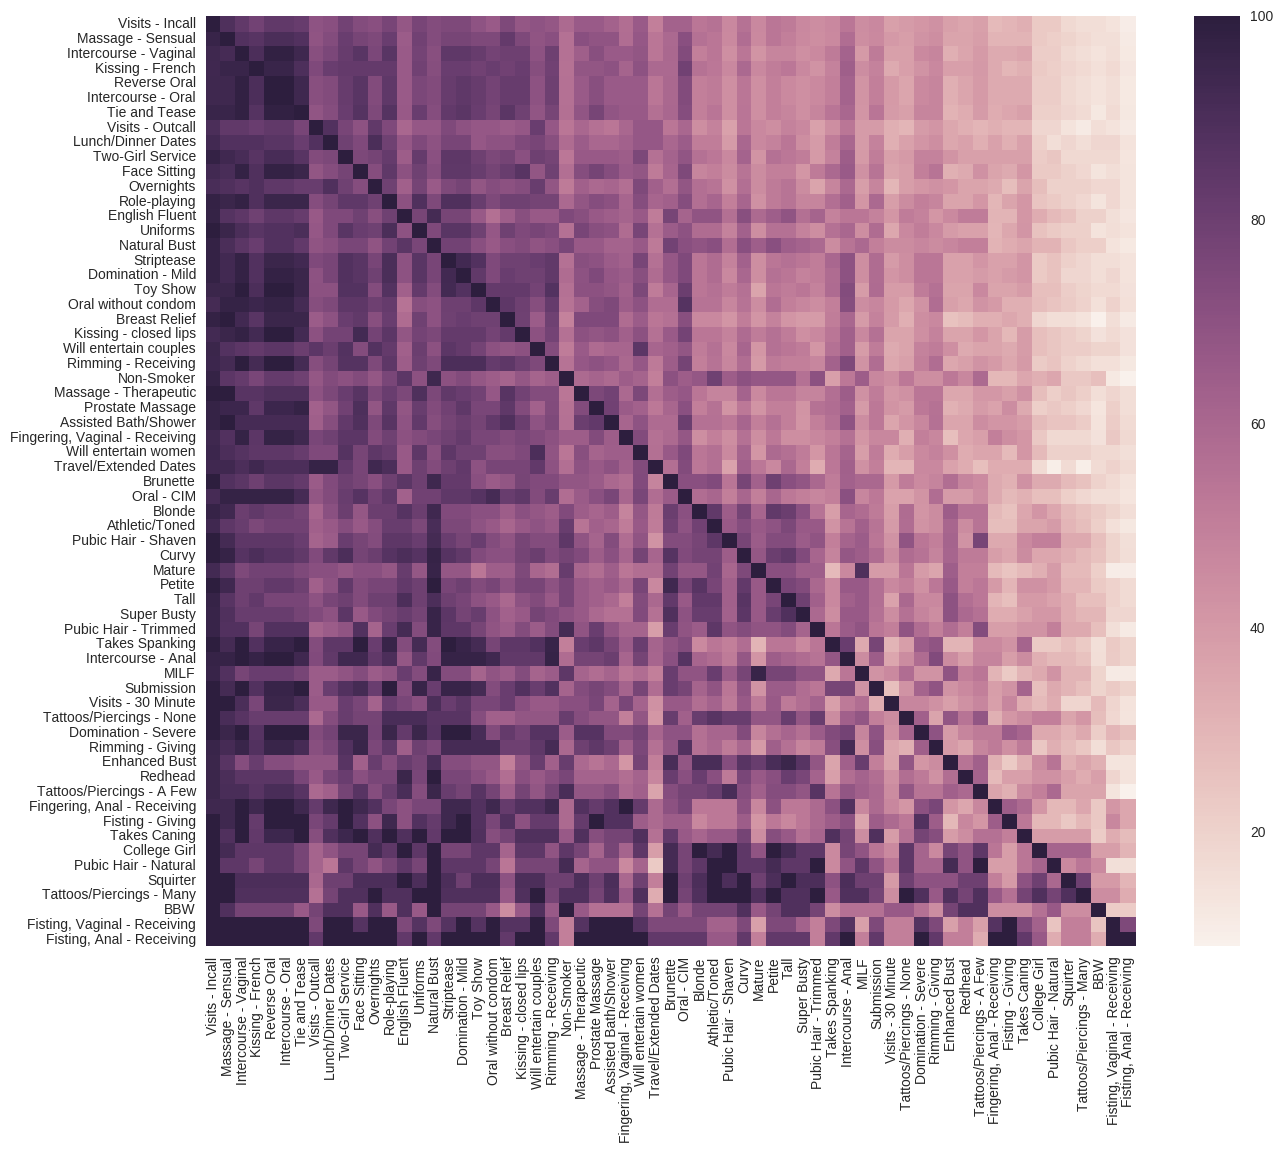

In [64]:
plt.figure(figsize=(15,12))
K = np.zeros((len(services), len(services)))
for k0 in range(len(services)):
        for k1 in range(len(services)):
                K[k0,k1]= (X[:,k0] & X[:,k1]).sum()/float(X[:,k0].sum())


labels = services
tmp = pd.DataFrame(100*K, columns = labels, index = labels)
sb.heatmap(tmp)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

This figure shows the frequency the service in the *horizontal* axis appears when the service in the *vertical* axis is performed. 

In [65]:
display(Markdown("""> *Example*: To know the frequency of **%s** when **%s** is provided, you go to the top-right corner, and the result is **%.1f%%**""" %  (services[-1], services[0], K[0,-1]*100) ))

> *Example*: To know the frequency of **Fisting, Anal - Receiving** when **Visits - Incall** is provided, you go to the top-right corner, and the result is **10.7%**

Some *insights* from this graph:

In [66]:
advertised_as = "MILF"
perform = "Mature"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies labeled as **%s** (acronym for *Mother I'd Like to Fuck*) are also labeled **%s** a (**%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Tattoos/Piercings - A Few"
perform = "Pubic Hair - Shaven"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies displaying **%s** have **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Pubic Hair - Natural"
perform = "Tattoos/Piercings - A Few"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies with **%s** also have **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Non-Smoker"
perform = "Natural Bust"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies labeled as **%s** have **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Petite"
perform = "Natural Bust"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies labeled as **%s** have **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Curvy"
perform = "Natural Bust"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies labeled as **%s** have **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Submission"
perform = "Role-playing"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* While ladies performing **%s** are into **%s** (**%.1f%%**) ...""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Role-playing"
perform = "Submission"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* ... the opposite is not true. Ladies performing  **%s** also perform **%s** a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

advertised_as = "Toy Show"
perform = "Oral - CIM"
idx_perform = services.index(perform)
idx_advertised_as = services.index(advertised_as)
display(Markdown("""* Ladies performing **%s** also perform **%s** (acronym for *Cum In Mouth*) a **%.1f%%** of times.""" %  (advertised_as, perform, K[idx_advertised_as,idx_perform]/0.01))) 

* Ladies labeled as **MILF** (acronym for *Mother I'd Like to Fuck*) are also labeled **Mature** a (**96.2%** of times.

* Ladies displaying **Tattoos/Piercings - A Few** have **Pubic Hair - Shaven** a **90.9%** of times.

* Ladies with **Pubic Hair - Natural** also have **Tattoos/Piercings - A Few** a **100.0%** of times.

* Ladies labeled as **Non-Smoker** have **Natural Bust** a **94.1%** of times.

* Ladies labeled as **Petite** have **Natural Bust** a **100.0%** of times.

* Ladies labeled as **Curvy** have **Natural Bust** a **96.8%** of times.

* While ladies performing **Submission** are into **Role-playing** (**100.0%**) ...

* ... the opposite is not true. Ladies performing  **Role-playing** also perform **Submission** a **59.1%** of times.

* Ladies performing **Toy Show** also perform **Oral - CIM** (acronym for *Cum In Mouth*) a **80.5%** of times.

## Most lucrative fetishes

In [67]:
display(Markdown("""Now, there only a handful (%s) of services offered. The question arises, are some **services more profitable than others**? And if so, which ones?""" %  (len(services)) ))

Now, there only a handful (63) of services offered. The question arises, are some **services more profitable than others**? And if so, which ones?

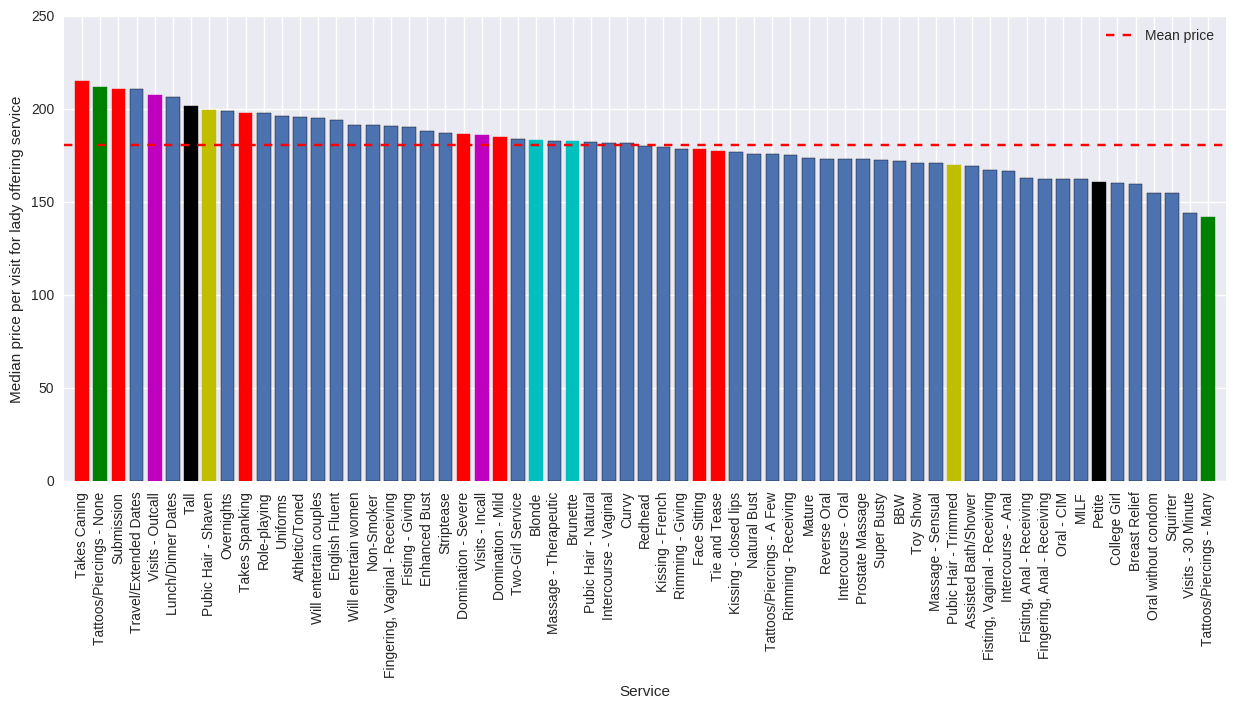

In [68]:
plt.figure(figsize=(15, 6))
means = [y[X[:,i]].mean() for i in range(len(services))]
services_ordered, means_ordered = zip(*sorted(zip(services, means), key = operator.itemgetter(1), reverse=True))
barlist = plt.bar(np.arange(len(means_ordered)),means_ordered, tick_label=services_ordered, width=0.75, align='center')
[barlist[v].set_color('r') for v in [0,2,9, 21, 23,-28, -29]]
[barlist[v].set_color('g') for v in [1,-1]]
[barlist[v].set_color('y') for v in [7,-15]]
[barlist[v].set_color('c') for v in [25,27]]
[barlist[v].set_color('m') for v in [4,22]]
[barlist[v].set_color('black') for v in [6,-7]]


mean_price = np.mean(means)
plt.plot([-1,len(services_ordered)],[mean_price, mean_price],linestyle='dashed',c='red', label="Mean price")


plt.xticks(rotation='vertical')
plt.xlim((-1,len(freqs)))
plt.xlabel("Service")
plt.ylabel("Median price per visit for lady offering service")
plt.legend()
plt.show()

This graph shows a representative price (the median) among all the ladies who offer each service. Careful! It *doesn't* mean that the lady necessarily *performed* said service, just that she is available to do so.

* **Red bars** show services related to Sadomasochism (from here on abbreviated *SM*), that includes *Caning* (being hit by a cane), *Spanking*, *Domination*, *Facesitting* and *Tie and Tease*. Next section focuses on this fetish.

* **Green bars** show the contrast between the ladies who advertises as having *Tattoos* or *Piercings*, being more profitable to advertise as *not having them*. Interestingly enough, next section will show that although escorts (or agencies) advertising Tattoos have a lower median income *per visit*, analyzing the descriptions clients don't seem to care.

* **Magenta bars** show that ladies offering *Outcalls* (she goes to the client's place) earn more that those who receive clients at their place (*Incall*).

* **Black bars** show that ladies advertising as *Tall* earn more than those advertising as *Petite*.

* **Yellow bars** show that clients prefer *Shaved Pubic Hair* as *Trimmed*.

* **Cyan bars** show that there is no significant difference in income between *Blonde* and *Brunette*

## SM? Tattoos?

The graph above seems to indicate that SM activities are well paid. But remember, that's only according to what ladies *display* in their profile. It doesn't necessarily mean that they are carrying out SM activities in the visit itself.

To confirm this fact, let's find the visits where SM *was* carried out (by looking at who used SM related words, like *spank* or *canning*) and compare their average cost with the rest.

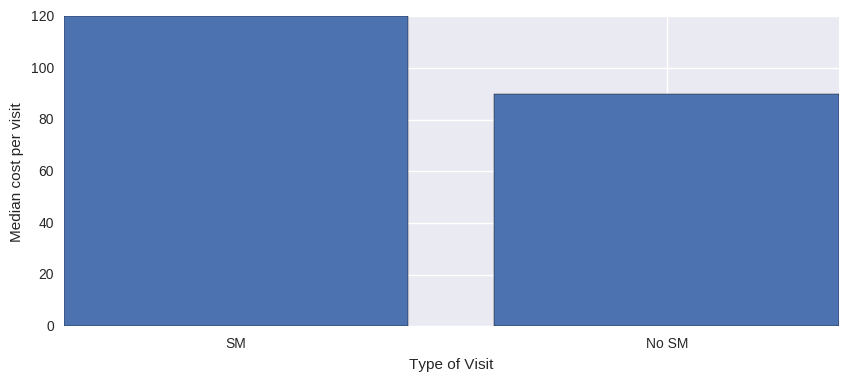

In [69]:
plt.figure()
df_reviews['story_description'][df_reviews.story_description==-1]=""
sm_idx=df_reviews.story_description.str.lower().str.contains("canning|submit|spank|dominatrix|domination|worship|mistress")
plt.bar([0,1],[df_reviews[sm_idx].amount_paid.median(), df_reviews[~sm_idx].amount_paid.median()], tick_label=["SM", "No SM"], align='center')
plt.xlabel("Type of Visit")
plt.ylabel("Median cost per visit")
plt.show()

In [70]:
display(Markdown("""This graph shows that **visits where SM is performed are, on average, a %d%% more profitable**. Now the question, was it a fad or the interest is *growing*?""" %  ((df_reviews[sm_idx].amount_paid.median()-df_reviews[~sm_idx].amount_paid.median())/0.01/df_reviews[~sm_idx].amount_paid.median())) )

This graph shows that **visits where SM is performed are, on average, a 33% more profitable**. Now the question, was it a fad or the interest is *growing*?

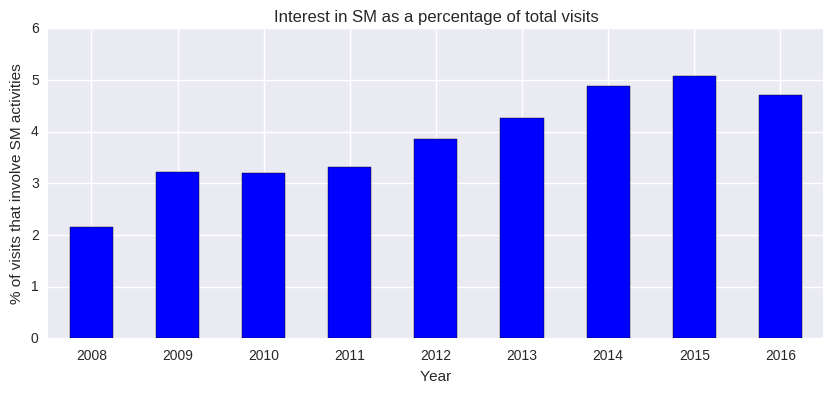

In [71]:
def isSM(v):
        q = v.str.lower().str.contains("canning|submit|spank|dominatrix|domination|worship|mistress")
        if len(q)==0:
                return np.nan
        return 100*q.sum()/float(len(q))

plt.figure()
plt.title("Interest in SM as a percentage of total visits")
df_reviews['story_description'][df_reviews.story_description==-1]=""
a = df_reviews[df_reviews.visit_date>datetime.datetime(2009,1,1)].groupby(pd.Grouper(key='visit_date', freq='12M')).story_description.apply(isSM)
a.index-=datetime.timedelta(days = 365)
ax =a.plot(kind='bar', tick_label=a.index.year)
ax.set_xticklabels([dt.year for dt in a.index.to_pydatetime()])
plt.xticks(rotation='horizontal')
plt.xlabel("Year")
plt.ylabel("% of visits that involve SM activities")
plt.show()


That's interesting, it seems that the **percent** of visits that involve SM activities has been growing since 2009! Maybe due to the success of the book and movie series *Fifty Shades of Grey*?

Now let's analyze the effect of **Tattoos and Piercings**.

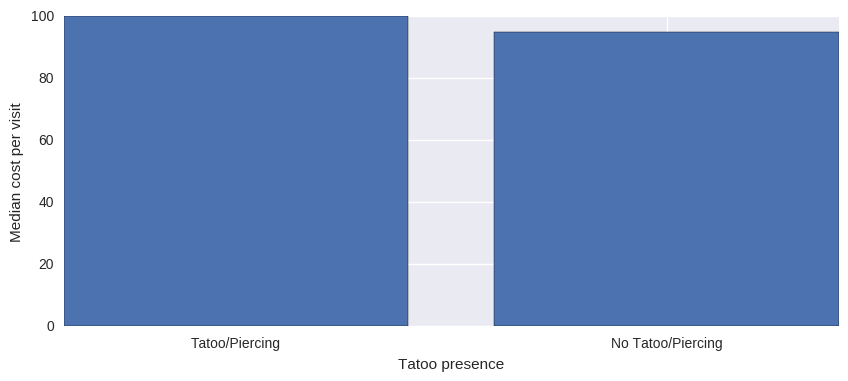

In [72]:
plt.figure()
df_reviews['lady_description'][df_reviews.lady_description==-1]=""
tatoo_idx=df_reviews.lady_description.str.lower().str.contains("tatoo|piercing")
plt.bar([0,1],[df_reviews[tatoo_idx].amount_paid.median(), df_reviews[~tatoo_idx].amount_paid.median()], tick_label=["Tatoo/Piercing", "No Tatoo/Piercing"], align='center')
plt.xlabel("Tatoo presence")
plt.ylabel("Median cost per visit")
plt.show()

This graph shows that it doesn't seem to matter in reality, contradicting the figure above. That raises an interesting point. Maybe girls who *do* say they have tattoos seem less interesting, but in reality the client doesn't mind?

# A look at the descriptions

Let's make a *wordcloud* of the descriptions for the *most loved* ladies and for the *least loved*.

In [73]:
most_loved_providers = df_reviews[df_reviews.id_service_provider!=-1].groupby("id_service_provider").story_sentiment.mean().sort_values(ascending=False)

**Most** loved ladies (according to reviews)

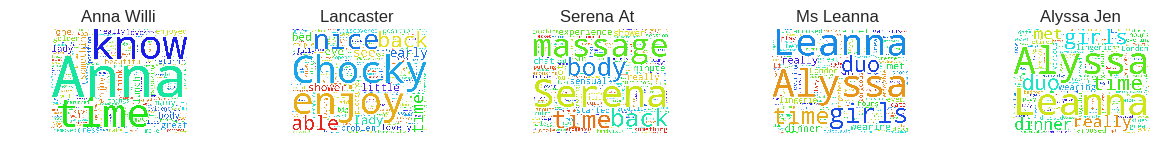

In [74]:
plt.figure(figsize=(15, 3))
for i,provider_id in enumerate(most_loved_providers.head(5).index):
        plt.subplot(2,5,i+1)
        plt.title(df_providers[df_providers.id_service_provider==provider_id].name.iloc[0][:10])
        makeWordCloud(df_reviews[df_reviews.id_service_provider==provider_id].story_description.str.cat())
plt.show()

**Least** loved ladies (according to reviews)

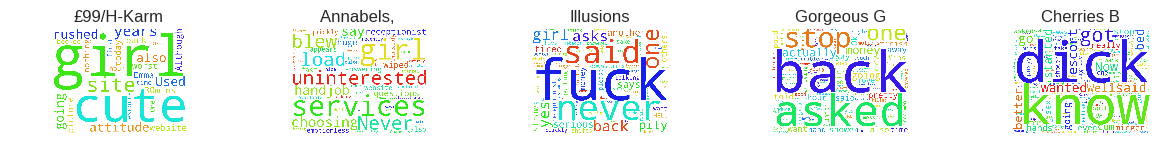

In [75]:
plt.figure(figsize=(15, 3))
for i,provider_id in enumerate(most_loved_providers.tail(5).index):
        plt.subplot(2,5,i+6)
        plt.title(df_providers[df_providers.id_service_provider==provider_id].name.iloc[0][:10])
        makeWordCloud(df_reviews[df_reviews.id_service_provider==provider_id].story_description.str.cat())

plt.show()

These pictures show the most common words found in the descriptions provided by the clients. We can easily check that among the **top girls** there are **positive words** like *enjoy*, *nice*, *great*, *time* (probably from *a good time*), as well as descriptions of the activities carried out, like *massage*, *dinner* or *shower*.

Conversely, among the **least liked** we find **negative words** like *uninterested*, *never*, *asked* and *stop* (maybe from sentences like *I asked her to stop*?).

I was surprised to find positive words in the bottom line, specially regarding the girl's appearance, like *cute*. That points to the fact that just physical attractiveness (which maybe is taken for *granted*) does not ensure client's satisfaction, but the escort is also expected to show *interest*.

Now, we can carry a global analysis from *all the descriptions* and check what words are most common.

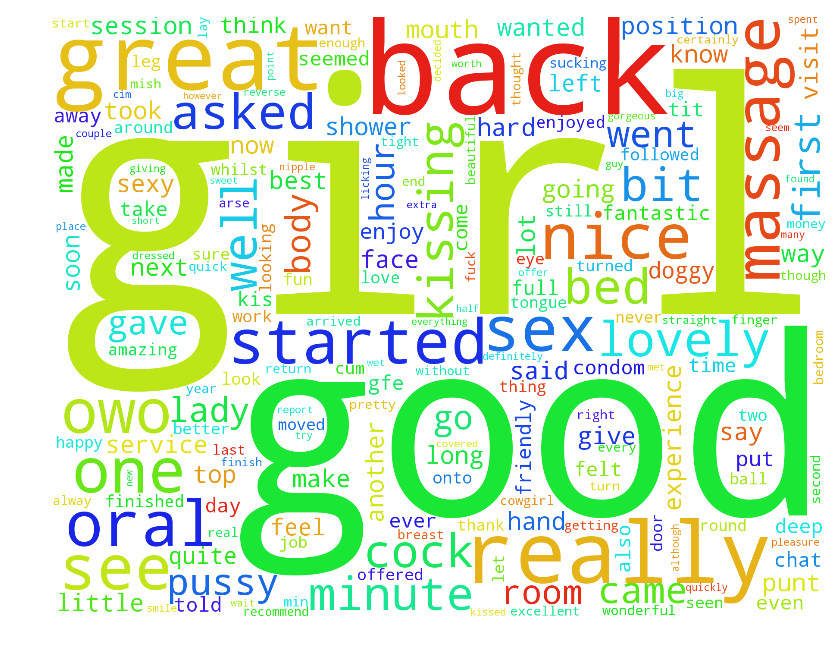

In [76]:
plt.figure(figsize=(10, 10))
reviews = ' '.join(list(df.story_description[df.story_description!=-1])).lower().replace(".","").replace("!","").replace("?","").replace(";","").replace("&","").replace(":","").replace(",","")
wordlist = [x for x in reviews.split(" ") if x not in stop_words+[""]]
makeWordCloud(' '.join(wordlist))
plt.show()

This figure is presented more for the *aesthetics* than for the analytical value. In any case, it's composed mainly by positive words like *good*, *nice*, *well*, *enjoyed*, *amazing* or *sexy*,  as well as words *associated* with positive experiences (mainly, but not only, sexual acts), like *sex*, *massage*, *smile*, *oral*, *cock* or *pussy*.

# Why do men go to escorts?

This section is the ** *most* speculative and biased**. The aim of the author is not to emit moral or social judgments, but rather to make his best to extract information from the data. The reader with domain knowledge is welcome to contact the author to express his/her (dis)agreements and perceptions. But careful, experience is *extremely* important, but do not forget that we humans are victims of our own biases. The intent of the report is to extract value from raw, unopinionated data, while corrections based on experience are welcome to improve its accuracy.

In [77]:
display(Markdown("""Some of these conclusions came by serendipity taking a look at the data, especially at the story description. While simple analysis can be automated (like word counting or sentiment analysis), reading *some* of the **%s reviews** gave new insights.""" %  (df_reviews.shape[0]) ))

Some of these conclusions came by serendipity taking a look at the data, especially at the story description. While simple analysis can be automated (like word counting or sentiment analysis), reading *some* of the **32115 reviews** gave new insights.

The first section of this report showed that clients go to the ladies during *working hours, on working days*. That, tied to the fact that the price is about **&#163;100** (median price) for visits of one-hour or less *and* the literacy of the reviewers, leads to believe that the typical client is a good-positioned, married, well-educated male in his **40's**.

**If that's the case**, surely taking a look at the descriptions which include the phrase *my wife* will give interesting information. Those clients are not only *married*, but they reference their *current wife*. That means, *at the very least* these men are married, and (*many*?) more who just didn't talk about their wife.

In [78]:
mywife = df_reviews[df_reviews.story_description.str.lower().str.contains("my wife")]

In [79]:
display(Markdown("""Here is an extract of **2** out of the **%d** descriptions found.""" %  (mywife.shape[0]) ))

Here is an extract of **2** out of the **40** descriptions found.

In [80]:
HTML(mywife.story_description.head(2).to_frame().to_html().replace("\\n","").replace("\\r","").replace("my wife","<b>my wife</b>"))

,story_description
957,"Now what to say here? I had a spare few hours while my wife was getting her hair done, alo..."
1169,Met Andrea with my wife. She was prompt and accepted the payment agreed beforehand. Well dressed...


As expected, these two reviews show something interesting about the motivation of client.
Quoting the first one
>I decided to pay Cat a visit to kill some time.

While the second one talks about a threesome including his wife.

Let's take a look at the rest of reviews, but in order to save space let's just show the text around the phrase *my wife*

In [81]:
def findAround(s, tofind="my wife", pre=10, post=10):
        if tofind in s:
                idx = s.lower().index(tofind)
                tmp_pre = s[:idx].split(" ")[-pre:]
                tmp_post = s[idx:].split(" ")[:post]
                return "..."+' '.join(tmp_pre+tmp_post).replace("  "," ")+"..."

        return ""


df_reviews.loc[df_reviews.story_description==-1,'story_description'] = ""
q = df_reviews.story_description.apply(findAround)
q.index.name = "Review Id"
q.name =" Story Excerpt"
HTML(q[q!=""].to_frame().to_html().replace("\\n","").replace("\\r","").replace("my wife","<b>my wife</b>"))

,Story Excerpt
Review Id,
957,"...say here? I had a spare few hours while my wife was getting her hair done, along with h..."
1169,...Met Andrea with my wife. She was prompt and accepted the payment agreed...
5398,...and didnt rush anything. It started with Sam and my wife kissing on the edge of the bed then...
7616,...I was very disappointed. I've had better BJs from my wife. Half way through I asked her...
8131,"...I asked for she delivered. How can I get my wife to do things like that. Would I recommend,..."
9721,...situation since I haven't had a woman other than my wife jerk me off in 17 years. I...
10151,"...things to me that nobody else has ever done, my wife or previous girlfriends included.A..."
10926,"...her that she`d starred in several adult films ""screw my wife please"" , ""Something about jack""..."
11489,...oil off my back when we had finished so my wife wouldn't know what I had been up to....


This table shows some reasons. In no particular order:

* *To kill the time*
* *Threesome*
* *Dissatisfaction* with his wife 
* *Girlfriend Experience*
* Recent *breakup*
* To *prepare* himself for his wife?

In [82]:
display(Markdown("""Regarding this last point, I found particularly interesting the story **11848** where he says *%s* There is another review, number **15576** where somebody says *%s*, which reminds of the first one. *Are they the same?* But first take a look at those full descriptions:""" %  (q[11848].split("But that is")[0], q[15576]) ))


display(Markdown("""** Review 11848 from %s, on %s (Duration: %s minutes) **""" %  (df_reviews.loc[11848].username, df_reviews.loc[11848].visit_date.strftime("%A %B %-d %Y at %H:%M"), int(df_reviews.loc[11848].duration_visit_minutes)) ))
display(Markdown("""> *%s*""" %  (df_reviews.loc[11848].story_description) ))

display(Markdown("""** Review 15576 from %s, on %s (Duration: %s minutes) **""" %  (df_reviews.loc[15576].username, df_reviews.loc[15576].visit_date.strftime("%A %B %-d %Y at %H:%M"), int(df_reviews.loc[15576].duration_visit_minutes)) ))
display(Markdown("""> *%s*""" %  (df_reviews.loc[15576].story_description) ))

display(Markdown("""**%s** wrote **%s reviews**, so for the sake of completeness here is the last one: """ %  (df_reviews.loc[15576].username, (df_reviews.author_link=="/authorprofile.php?unum=75170").sum()) ))


elem = df_reviews[df_reviews.author_link=="/authorprofile.php?unum=75170"].iloc[2]
display(Markdown("""** Review %s from client %s, on %s (Duration: 30 minutes) **""" %  (elem.review_id, elem.username, elem.visit_date.strftime("%A %B %-d %Y at %H:%M")) ))
display(Markdown("""> *%s*""" %  (str(elem.story_description)) ))

Regarding this last point, I found particularly interesting the story **11848** where he says *...I left a very happy horny man ready for my wife. * There is another review, number **15576** where somebody says *...very short. I had planned to save myself for my wife later but the way she looked at me...*, which reminds of the first one. *Are they the same?* But first take a look at those full descriptions:

** Review 11848 from geoff2008, on Thursday June 4 2009 at 15:30 (Duration: 30 minutes) **

> *On this occassion I chose Stephanie and on arrival was taken into one of the two bedrooms. I explained taht I want her to undress me and for me to undress her and was looking for just a tease. She went out to get ready and when she retuned she found I had taken some of my clothes off and was told off. I then slowly ran my hands over her body and unzipped her to expose her great boobs. We were soon both naked and I was taken to the bed where I lay facer down while she ran her hand over my back, legs and thighs. She ran them up between my legs touching my private bits sending tingle through my body. I then turned over and she played with me bring me to the edge on several occassion and then pulling back. I then played with her running my hands all over her body which aroused me more and I nearly came several times. We talked about sex and my fantasties which really turned me on. The great thing about her was that she honoured my request not to cum and I left a very happy horny man ready for my wife. But that is another story between her and me and Stephanie when we meet again. Thanks Stephanie. I will be back.*

** Review 15576 from geoff2008, on Wednesday July 7 2010 at 13:15 (Duration: 25 minutes) **

> *I have been with stephanie before and always had a great time. It has been a while since I have visited her and she is still as good as ever at giving just waht I want. I had asked her to undress me and this she did in a slow sensuous way while I slowly stripped her. I held her breasts while she played gently with my naughty bits until I was hard and throbbing. At which point I lay on the bed face down while she continued to caresse me from behind and rubbed her self over my back. Eventually I had to turn round and she seized on my standing member and slipped on the cover to begin oral. What heaven I was in she has a great oral technique. Which receiving oral I had a wonderful view of her pussy and played with played with it gently. I had to stop her several times otherwise my stay would have been very short. I had planned to save myself for my wife later but the way she looked at me I decided to let go and had the most mind blowing orgasm in years. I must come back sooner next time. Thanks Stephanie. you were great. Treat her well and enjoy*

**geoff2008** wrote **3 reviews**, so for the sake of completeness here is the last one: 

** Review 103827 from client geoff2008, on Thursday May 12 2011 at 11:00 (Duration: 30 minutes) **

> *Welcomed with a great smile at the door and quick kiss. Shown upstairs into the bedroom - large double bed and dealt with the formalities. As requested on the phone she slowly removed her clothes with some assistance from me. Couldn't wait to feel those great boobs and I was not disappointed. Cuddled up and ran my hands between her legs to feel her shaved pussy. By now she had remove some of my clothes and was inside my pants feeling my cock which was rising. Once naked we both lay on the bed and cuddled up together as she slowing played with my cock. Holding my balls gently in her hand and with the other hand teasing the tip of my penis. I was in heaven. We entwined ourselves with our bodies pressed against each other. Several times I was close to cumming as my cock ribbed against her body and she held my balls but Nicky knew when to pull back. It was then on with the cover and she went down on me with some fantastic oral deep in her mouth and again would have exploded but wanted to feel her warm pussy around my cock. She raised herself over my cock slowly slid down on me. I could feel the tightness and warmth of her pussy around my cock and then with her boobs bouncing road me until I could take no more. I shot my load cumming again and again. A fantastic time. Afterwards there was no rush as I dressed and chatted with her. Treat her well. I will be back for more.  Thanks. I am still tingling.*

And this quote, that I just couldn't leave out:

In [83]:
tmp =  df_reviews.loc[23459]
display(Markdown("""On **%s** by **%s**""" %  (tmp.visit_date.strftime("%A %B %-d %Y at %H:%M"), tmp.username) ))
display(Markdown("""> *%s*""" %  (tmp.story_description.replace("to shag this fat walrus finished off thinking about my wife in the bath", "**to shag this fat walrus finished off thinking about my wife in the bath**").replace("\n","").replace("?","'"))) )

On **Friday August 24 2012 at 19:00** by **long dong dave**

> *Was in the mood to try something different, so was offered a big lady size 18 (she was bigger than a 18)  have to admit i was intrigued never has a bbw before,  when Helen called me back was kind of put off with her abrasive Irish accent, but she has the patter and she's up for anything and will do anything asked, so appointment was organised. I have to admit i considered cancelling and was close to doing this right up till she opened the door and i really wish i did take to my heals and ran. She instantly took charge, as she undressed my stomach was lurching i knew this was a mistake, i closed my eyes as she attempted to give me owo, finally gave up and asked her to turn over so i could take her from behind but she was so big this was impossible, only option was anal at extra charge. I had to keep my eyes closed and think about having sex with someone else **to shag this fat walrus finished off thinking about my wife in the bath**, that did the trick and that's a first for my 10 years of punting that I've ever had to do this,  got dressed and left, very disappointed with my first ever encounter with a large lady, I can safely say i will never be revisiting this women. Wish i had requested a photo before appointment I'm sure there are big women out there who can pull off the bbw and have the looks to work in this area but Helen is certainty not one of them ,  one for the bucket list though. *

Neither this one:

In [84]:
tmp =  df_reviews.loc[10859]
display(Markdown("""On **%s** by **%s**""" %  (tmp.visit_date.strftime("%A %B %-d %Y at %H:%M"), tmp.username) ))
display(Markdown("""> *%s*""" %  (tmp.story_description.replace("let me take the lead (important for couple - saves on arguments later!", "**let me take the lead (important for couple - saves on arguments later!**").replace("\n","").replace("?","'"))) )

On **Wednesday February 4 2009 at 08:30** by **marlis2008**

> *Arrived exactly at 8.30  with husband  to the shock of the 4 blokes in reception who hadn't booked and were hoping for a no show, went straight upstairs, Bailey arrived soon after made us feel very  welcome. Great massage whilst husband was in shower, fabulous with hands and tongue, **let me take the lead (important for couple - saves on arguments later!**) would certainly recommend to other couples thinking about this sort of thing! following lots of playing both me and partner finished more than satisfied!*

In [85]:
def findAround(s, tofind="boyfriend", pre=10, post=10):
        if tofind in s:
                idx = s.lower().index(tofind)
                tmp_pre = s[:idx].split(" ")[-pre:]
                tmp_post = s[idx:].split(" ")[:post]
                return "..."+' '.join(tmp_pre+tmp_post).replace("  "," ")+"..."

        return ""


df_reviews.loc[df_reviews.story_description==-1,'story_description'] = ""
q = df_reviews.story_description.apply(findAround)
q.index.name = "Review_Id"
q.name =" Story Excerpt"

In [86]:
display(Markdown("""Not only the clients talk about their *wives*, but ladies often talk about their *boyfriends*, too. A search for the word *boyfriend* showed **%s** results (of course not all occurrences mean she *has* a boyfriend).""" %  ((q!="").sum()) ))

Not only the clients talk about their *wives*, but ladies often talk about their *boyfriends*, too. A search for the word *boyfriend* showed **113** results (of course not all occurrences mean she *has* a boyfriend).

In [87]:
HTML(q[q!=""].head(20).to_frame().to_html().replace("\\n","").replace("\\r","").replace("boyfriend","<b>boyfriend</b>"))

,Story Excerpt
Review_Id,
278,"...She tells me she does a double with her boyfriend. Now I have always fancied that, so n..."
429,"...her strongest asset... except that she talked about her boyfriend. Advertises herself as 19, ..."
771,"...made me feel as if I was her permanent boyfriend/partner, it was like I was coming home after..."
889,"...comfortable, in fact, that I felt more like a boyfriend than a punter.After orgasm I had ..."
909,...work & some of her private live with her boyfriend. I was told she'd had a lot of...
1506,"...though it?s my favourite position at home. ?It?s my boyfriend?s favourite too,? she informed ..."
1800,"...work. Ask her what she gave to her boyfriend for his birthday, lucky b*****d!Would I re..."
2271,...me feel so good. We kissed like girlfriend & boyfriend and carressed each others bodies. Tyle...
2295,...a about a disgusting session she had with an ex- boyfriend while at a club with a current boy...


While this excerpt (first *20* stories) show that sometimes escorts *do* have boyfriends *and* talk about them, it was hard to gauge how secret her activities are. In some cases *he* seems to be informed -and even participative- and many other cases the word *boyfriend* was referring to how she treated the client, in a positive way.

Next question: *are girls married?* and if so, *do they talk about their husbands?*.

In [88]:
def findAround(s, tofind="husband", pre=10, post=10):
        if tofind in s:
                idx = s.lower().index(tofind)
                tmp_pre = s[:idx].split(" ")[-pre:]
                tmp_post = s[idx:].split(" ")[:post]
                return "..."+' '.join(tmp_pre+tmp_post).replace("  "," ")+"..."

        return ""


df_reviews.loc[df_reviews.story_description==-1,'story_description'] = ""
q = df_reviews.story_description.apply(findAround)
q.index.name = "Review_Id"
q.name =" Story Excerpt"

In [89]:
display(Markdown("""A search for the keyword **husband** gives **%d**. But again, there might be false positives. Let's take a look at the excerpts.""" %  ((q!="").sum()) ))

A search for the keyword **husband** gives **19**. But again, there might be false positives. Let's take a look at the excerpts.

In [90]:
HTML(q[q!=""].head(20).to_frame().to_html().replace("\\n","").replace("\\r","").replace("husband","<b>husband</b>"))

,Story Excerpt
Review_Id,
865,...So where were all the hungry housewives chasing disloyal husbands? Why was South London so qu...
2445,...I was shown to a second room by her husband - he stayed and chatted for a while before...
4229,...again very soon to book a session where her husband joins in a threesome. I can't wait!...
5070,"...Lovely to chat to as well. Oh, and my husband assures me she really likes guys, too. ..."
5140,"...some lucky so and so called Steve? her lucky husband?. A true professional lady, I could not ..."
6317,...can this girl kiss. I felt like a returning husband who had been at sea for six months.She le...
10859,...Arrived exactly at 8.30 with husband to the shock of the 4 blokes in...
15033,... Next time I'm booking an hour with her husband aswell for an even more mind blowing experien...
16253,...as well.Debbie wears her engagement and wedding ring (her husband knows her trade and built h...


In [91]:
display(Markdown("""This case is *clearer*. First, only **%s** of the **%s** total reviews (or **1** each **%s**) mention the word **husband**. But when they do, it's mostly in a participative context. There are also some instances of using the word *husband* as in *caring husband* in a positive context.""" %  ((q!="").sum(), q.shape[0], "%d" % (q.shape[0]/1.0/((q!="").sum()))) ))

This case is *clearer*. First, only **19** of the **32115** total reviews (or **1** each **1690**) mention the word **husband**. But when they do, it's mostly in a participative context. There are also some instances of using the word *husband* as in *caring husband* in a positive context.

In case you are wondering about review *19211* (*...take sexual advantage of his pregnant employee, Lucy, whose husband also worked for me. This meant she really had...*) it was just a role-play. Here is more context:

In [92]:
tmp =  df_reviews.loc[19211]
display(Markdown("""On **%s** by **%s**""" %  (tmp.visit_date.strftime("%A %B %-d %Y at %H:%M"), tmp.username) ))
display(Markdown("> [...]*I was to play the role of a powerful businessman who was going to take sexual advantage of his pregnant employee, Lucy, whose husband also worked for me.*[...]"))

On **Thursday June 16 2011 at 13:00** by **the teacher**

> [...]*I was to play the role of a powerful businessman who was going to take sexual advantage of his pregnant employee, Lucy, whose husband also worked for me.*[...]

Let's analyze some other keywords. For example, **divorce** and **ex-wife**, to look for stories regarding a recent breakup.

Here are some stories including these words:

,Story,username
2561,"She is a total babe, the sort of girl you would love to spend more time with. She gives a true girlfriend experience and more. What would I do to take her home. Appart from needing divorce papers. Treat this lady with respect and you will be well rewarded. Will be back again and again and again im hooked.",sexypaul999.
4136,Having taken a few days off work I planned to spendsome hard earnt cash at Sandy's. This morning my divorce came though and whilst checking the internet saw Carla. A quick call and I was booked in by the delightful Debbie.! . On the way I decided to see If she was available for an hour and luckly she was.I wanted to be looked after and pampered and Carla did this without me asking. She came into the room just asi finished in the shower. A quick chat and the fun started. The massage was good andsoon improved with a body to body massage and some light kissingon the back. Turned over and enjoyed the veiw as well as the massage. I'm sure this girl is a mind reader cos I love having my nipples sucked and played with. Just about to ask when she did just that. OWO was out of this world (something my ex wife never did as oral is disgusting apparently!!) After a bit on with the mac off with the nickers and there was the most beautiful shaven pussy that I've ever seen!!. Started off with cow...,Charlie B
8983,Well i was not going to write a report so as no one else would know about this gem of a Lady but that would be me being selfish. She is a lady in all respects just fantastic. If i had met her years ago and covinced her to marry me i would not have been divorced twice she ticks all my boxes and found some more boxed that i did not know about to tick! If you are looking for a Lady that will spoil you beyond your dreams she is the one. Gents please be nice to her as she is one in a million. I just wish i did not have to fly out of the UK for work or she would be on my weekly things to do.,windy873
11775,"I arrived late as I came by the underground, ZaZa was OK as I had texted her earlier. I was greeted at the door with her wearing a black basque with stockings, the highest heels I have ever seen & with that lovely smile & led me to a basement bedroom. At this time my heart was racing, heres me at 52 recently divorced & taking a punt at seeing a girl for the first time. I wanted to jump on her there & then but was offered a shower by ZaZa which I accepted as I came from work. ZaZa offered to join me in the shower but I said it was OK as I felt a bit nervous. So after shower she gestered me very sexily to the bedroom, I was half mast after the shower but now I was so hard as she was whospering sweet nothings to me. She went down on my cock & sucked so deep and wet I could of come in seconds. Thanks to my age & experience I held out for a while, I now wanted to taste that sweet Oriental pussy that I had been dreaming of before coming here. ZaZa is shaven down below and I to...",Smoothrider
14087,"Initial kissing & touchy-feely then Naomi, sorry Shola, disappeared to do whatever they do with the beer vouchers. Took some time to come back but for once I didn't mind a bit. I had seen her, ever so politely run my hands all over her and spoken to her. Experience was already telling me this could be a punt extraordinaire. I was only too glad to lie back naked on the bed and spend the time in delirious anticipation. If I'd known the the full delights to come I might have been tempted to w*nk at the thought of it and done the job for her! Came back full of apologies and offered a massage. Hell no! A back rub was the last thing on my mind by this time. Some punts are such a thrill it's difficult to recall details. I can remember lots of kissing, cuddling plus other tit f*cking type foreplay. My finger in her pussy took decades off me. It felt just like being with a new GF back when I was doing this for real. So much so that I broke a taboo that's haunted me all my adult li...",Mick1515


,Story,username
1586,"A good ""solid"" punt. Or was that my cock? Tia is fairly quiet but just gave me a great VFM half hour. She has a lovely firm body, and to a man twice her age, the whole thing just felt exactly right. Quick massage, followed by OWO which was enthusiastic and hit the spot. I returned the favour (she tasted great). Sex in cowgirl was followed by missionary which just felt unusually GOOD. (Even she said that!). Finished off by hand over her boobs. This was not one of those wild crazy, wild, frantic punts, but rather more how I remember good sex with my ex-wife used to be. But enough of her, the bitch. Recommended - Tia will make you feel good.",capitalguy
22132,"So, how sexy is Eden? Mick Jagger and Keith Richards at the end of ?Start Me Up? (from the Stones? album ?Tattoo You? ? to keep with theme!) suggest an ability to ?make a dead man cum?! Well, I wasn?t exactly dead by the time Eden and I finally clapped eyes on each other, but I was having a fuck of a week (at work as well as having my ex-wife on my case ? NO ONE can wind you up like an ?ex?, right?!), so was very much looking forward to this session when, on arrival at venue, found booking had gone waaay awry ? nobody?s fault really, but Eden had gone to wrong location on other side of London and Amelia, as I waited in a nearby park, texted me to say that my 90 minutes would have to be only an hour coz of another booking after me in the flat! So, not a very auspicious start ? typical of the week I was having - and I?d kinda gone ?off the boil?! But ? and it?s a big BUT ? as soon as Eden opened the door and I saw how stunning she looked, heard that lovely voice, felt how deliciously...",Marshall1
22366,"Had a hard day? Boss/wife/ex-wife/kids doing your head in? Want to unwind? Then what you need is a lovely GFE session with Ilona! I was a bit stressed-up and, having seen Ilona a couple of times previously, thought she was just the tonic I needed. From the moment she greeted me at the door with her lovely smile and equally lovely kisses, I knew help was at hand! Had a relaxing catch-up over some fizz (was amazed at how much detail she remembered about me from my previous visits) before an equally relaxing shower. Back to the bedroom, stark bullock naked, whereupon Ilona got me down on the bed with a breathy ?Come to mama!? (loved it!) and we started the most amazing ?snogging? session. For a lady who appears initially so cool, calm and collected, she?s incredibly passionate once she gets going ? and that doesn?t take any time at all! Rolling around the bed, arms entwined around each other?s bodies and hands caressing anything that moved, we greedily explored each other?s mouths and...",Marshall1
23148,"If you?re a bit stressed-up and your ex-wife and daughter are doing your head in (and let?s face it, absolutely NOTHING can do your head in like an ex-wife/daughter combination!), then what you need is a session with Aisha to get your head straight and your juices flowing again! This was my fourth visit to this fabulous pocket-rocket Thai fire-cracker (twice on her own and once as a duo with the crazy-sexy Nana) ? speaks for itself how highly I rate her. And it was just what I needed. From the moment she greeted me at the door and took off my shoes in the hallway to the moment she laced them back on and kissed me as I took my leave, I was transported out of stressful reality into Aisha?s wonderful world where delicious sensuality mixes with raunch-a-go-go ? Aisha dedicates herself to giving you pleasure; she absolutely wants you to have the best time possible ? and she delivers! And it was all as before ? the saucy undressing leading to the shared, lovely hot bath with face flanne...",Marshall1
25369,"If you wanna meet a Greek Goddess, but the recession means you can’t afford the trip to Athens or Delphi, then truck on down to Canary Warf and see Suzy! Well, that’s what I did, and it was rather like an audience with the Oracle - calming, relaxing and enl

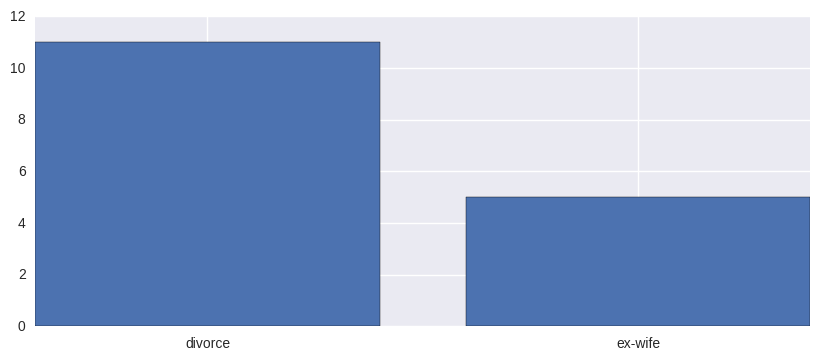

In [93]:
words = ["divorce", "ex-wife"]
freq = []
for word in words:
        idx = df.story_description.str.contains(word, case=False)
        idx[idx.isnull()]=False
        pd.set_option('max_colwidth', 1000)
        display(HTML("<h3>"+word.title()+"</h3>"))
        display(HTML(df[idx][['story_description','username']].head().to_html().replace("story_description","Story").replace("\\n"," ").replace("\\r","").replace(word,"<b>"+word+"</b>")))
        freq.append(idx.sum())
        
words_ordered, freq_ordered = zip(*sorted(zip(words, freq), key=operator.itemgetter(1), reverse=True))


plt.bar(np.arange(len(freq_ordered)), freq_ordered, tick_label = words_ordered, align='center')
plt.show()


# Epilogue and Conclusion

As a final note, the reader may have noticed that incomes were compared *by visit*, rather than *by hour*. This was a deliberate decision since at the view of the author the *income per hour* lead to wrong conclusions -as an extreme example, if one kiss costs &#163;1 at takes one second, would it be accurate to say the cost of that kiss that *&#163;3600 per hour*?

Another point was the mixed use of *median* and *averages*. They both have the same substance, but unfortunately the *average* is sensitive to extreme values, which are often typos (costs over &#163;1 Billion, for example). That's why for calculations involving data scraped from user input the *median* was chosen. To average *medianed* values the more traditional *average* was kept.